# Plutonium Maker
The purpose of this notebook is to investigate the performance of various pin-cell configurations in producing weapons grade plutonium.

The sorts of questions that I want to be able to answer:
1. What are the trade-offs in moderator selection
2. What should be the fuel pitch, diameter and/or pitch to diameter ratio?
3. How long should the fuel be left in the reactor for maximum production of plutonium? 
4.  I expect the answer to 3 to depend on the power density and the neutron energy spectrum.  I assume you should just operate at the maximum achievable power density (with respect to heat transfer requirements) but how does the neutron energy spectrum change things?
5. If I wanted to make Pu-238, how would the reactor core design change. (fuel, moderator, coolant, geometric arrangement, etc...)

After some initial investigations, I can investigate the available design information for early plutonium production reactors.  As much as is possible, I could try to observe how plutonium production reactor core design has changed over the years and try to infer the engineering rationale for the evolution. 

In short: I hope to build a *quantitative* intuition regarding these considerations.


In [1]:
import openmc
import numpy as np

%matplotlib inline

## Materials


In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=0.7)
#fuel.add_element("O", 2)
fuel.set_density("g/cc", 18.4)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

alum = openmc.Material(name='alum');
alum.add_element('Al',1);
alum.set_density('g/cc',2.7); #according to Google...

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # higher temperature water...
water.add_s_alpha_beta('c_H_in_H2O');

graphite = openmc.Material(name='graphite');
graphite.add_element('C',1);
graphite.set_density('g/cc',1.7);
graphite.add_s_alpha_beta('c_Graphite');

materials = openmc.Materials([fuel,clad,water,alum,graphite]);
materials.export_to_xml();

## Geometry
I will make a pin cell.  In order to (roughly) model a hanford pin cell I will use a uranium metal slug coated with aluminum in a graphite reflector cooled with water. 

In [3]:
h_core = 300.; # all dimensions in cm 
h_fuel = 200.;

r_fuel = 2.0;
r_pin = 2.1;
r_cool = 2.25;

P_D = 5.5; # with graphite moderator a relatively high P/D is needed for reasonable neutron economy
# 10 is too high, 3 is too low (0.889), 7 is too high again (0.974), 5.5 (.9959) 4.5 (0.9859), 5.0 (0.9935), 6.0 (0.9948)

# note that for P/D=5.5, if I eliminate the water from the cooling channel, keff jumps up to 1.0341 (!!)
# all of the above was with a fuel radius (without the clad) of 1 cm.

# when I increase the r_fuel to 2.0 with clad thickness and coolant channel "thickness" the same k_eff increases
# somewhat. Effectively this increases the atom fraction of fuel compared to coolant or cladding so it is likely to help.


pitch = P_D*r_cool*2.; # set P/D relative to the coolant channel diameter

# on later iterations add temperature effects to the fuel to see how important they are.

fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);
fuel.volume = np.pi*(r_fuel**2)*h_fuel;

pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

cool_ch_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2.+5.],
                                                h_core-10.,r_cool);
# note: I added some margin between the coolant cell upper and lower boundaries and the core.
# having those surfaces coincident resulted in lost particles.

core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl;
fuel_cell.fill = fuel;
fuel_cell.temperature = 800; #K, reminder to fill this in later

clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl
clad_cell.fill = clad;

cool_cell = openmc.Cell();
cool_cell.region = +pin_cyl & -cool_ch_cyl;
cool_cell.fill = water;

mod_cell = openmc.Cell();
mod_cell.region = +cool_ch_cyl & -core_cell;
mod_cell.fill = graphite;
mod_cell.temperature = 700; # K, just a guess




In [4]:
root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,cool_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

geometry.export_to_xml();


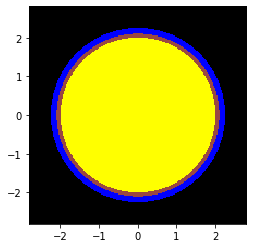

In [5]:
color = {}
color[fuel]='yellow';
color[alum]='gray';
color[water]='blue';
color[graphite]='black';

#root_univ.plot(width=(pitch,pitch),color_by='material',colors=color);
root_univ.plot(width=(2.5*r_cool,2.5*r_cool),color_by='material',colors=color);

## Settings
Initially we will just find what the eigenvalue is.  Since this will model a reactor that is infinite, the materials will need to be tweaked so that the eigenvalue is greater than 1.  

In [6]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 15000;
settings.batches = 150;
settings.inactive = 50;

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();


In [7]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      133/1    1.01476    1.00438 +/- 0.00106
      134/1    0.99034    1.00421 +/- 0.00106
      135/1    1.01428    1.00433 +/- 0.00106
      136/1    0.97702    1.00401 +/- 0.00109
      137/1    1.01444    1.00413 +/- 0.00109
      138/1    1.00485    1.00414 +/- 0.00107
      139/1    1.00982    1.00421 +/- 0.00106
      140/1    1.00784    1.00425 +/- 0.00105
      141/1    1.01609    1.00438 +/- 0.00105
      142/1    1.00537    1.00439 +/- 0.00104
      143/1    1.00233    1.00436 +/- 0.00103
      144/1    1.01609    1.00449 +/- 0.00102
      145/1    0.99840    1.00443 +/- 0.00101
      146/1    1.00872    1.00447 +/- 0.00100
      147/1    1.01265    1.00455 +/- 0.00100
      148/1    1.01543    1.00467 +/- 0.00099
      149/1    1.00870    1.00471 +/- 0.00098
      150/1    0.99348    1.00459 +/- 0.00098
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.1819e+00 se

## Depletion Calculation
Okay - this is a start.  I fully expect that the reactor, as modeled, will not remain critical once equilibrium Xe-135 and Sm-149 are established in the core.  The negative reactivity from the doppler broadening of the fuel didn't turn out to be such a big deal.

In [8]:
import openmc.deplete

operator = openmc.deplete.Operator(geometry,settings,"chain_casl_pwr.xml");
power = 1e4; # W, this is a guess

operator.heavy_metal

max_step = 2*operator.heavy_metal/power*1e3
print(f'Maximum recommended depletion step %5.3f days' % max_step);

Maximum recommended depletion step 9248.849 days


In [9]:

days = 24*3600; # seconds in a day
time_steps = [0.1*days,0.1*days,0.2*days,0.3*days,0.5*days,
              1.0*days,10.0*days, 100.0*days, 100.0*days, 200.*days,
             200.*days, 200.*days, 500.*days, 500.*days, 500.*days, 500.*days, 2000.*days];


In [10]:
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);
#integrator = openmc.deplete.CELIIntegrator(operator,time_steps,power=power);
integrator = openmc.deplete.SICELIIntegrator(operator,time_steps,power=power);

In [11]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd108.h5
 Reading Ag107 from /home/sblair/OMC_DATA/endfb71_hdf5/Ag107.h5
 Reading Ag109 from /home/sblair/OMC_DAT

 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5


          1200K
          2500K


 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd146.h5
 Reading Nd147 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT

      108/1    1.00522    1.00761 +/- 0.00112
      109/1    1.02060    1.00783 +/- 0.00112
      110/1    1.02878    1.00818 +/- 0.00116
      111/1    1.01723    1.00833 +/- 0.00115
      112/1    1.00626    1.00829 +/- 0.00113
      113/1    1.00288    1.00821 +/- 0.00111
      114/1    1.00711    1.00819 +/- 0.00110
      115/1    0.98484    1.00783 +/- 0.00114
      116/1    0.99026    1.00756 +/- 0.00115
      117/1    1.00073    1.00746 +/- 0.00114
      118/1    1.01744    1.00761 +/- 0.00113
      119/1    1.00486    1.00757 +/- 0.00111
      120/1    1.00652    1.00755 +/- 0.00110
      121/1    0.98187    1.00719 +/- 0.00114
      122/1    1.01266    1.00727 +/- 0.00113
      123/1    1.00295    1.00721 +/- 0.00111
      124/1    0.99729    1.00708 +/- 0.00111
      125/1    1.01598    1.00719 +/- 0.00110
      126/1    0.99252    1.00700 +/- 0.00110
      127/1    1.00075    1.00692 +/- 0.00109
      128/1    0.99718    1.00680 +/- 0.00108
      129/1    1.00256    1.00674 

      127/1    1.00634    1.00574 +/- 0.00099
      128/1    0.99529    1.00561 +/- 0.00099
      129/1    1.00893    1.00565 +/- 0.00098
      130/1    0.99057    1.00546 +/- 0.00098
      131/1    1.01280    1.00555 +/- 0.00098
      132/1    1.01477    1.00567 +/- 0.00097
      133/1    1.01125    1.00573 +/- 0.00096
      134/1    0.98611    1.00550 +/- 0.00098
      135/1    0.99394    1.00536 +/- 0.00098
      136/1    1.01059    1.00543 +/- 0.00097
      137/1    0.99354    1.00529 +/- 0.00097
      138/1    1.01636    1.00541 +/- 0.00096
      139/1    1.00389    1.00540 +/- 0.00095
      140/1    1.01367    1.00549 +/- 0.00095
      141/1    1.00714    1.00551 +/- 0.00094
      142/1    0.97988    1.00523 +/- 0.00097
      143/1    0.99506    1.00512 +/- 0.00096
      144/1    1.00590    1.00513 +/- 0.00095
      145/1    1.00342    1.00511 +/- 0.00094
      146/1    1.00602    1.00512 +/- 0.00093
      147/1    1.02377    1.00531 +/- 0.00094
      148/1    1.01980    1.00546 

      147/1    1.01464    1.00458 +/- 0.00105
      148/1    1.00366    1.00457 +/- 0.00104
      149/1    1.00998    1.00462 +/- 0.00103
      150/1    1.00538    1.00463 +/- 0.00102
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 9.4635e+01 seconds
   Time in transport only          = 9.4150e+01 seconds
   Time in inactive batches        = 2.6180e+01 seconds
   Time in active batches          = 6.8455e+01 seconds
   Time synchronizing fission bank = 2.1018e-01 seconds
     Sampling source sites         = 1.8829e-01 seconds
     SEND/RECV source sites        = 2.1303e-02 seconds
   Time accumulating tallies       = 1.2755e-01 seconds
   Time writing statepoints        = 1.1338e-02 seconds
 Total time for finalization       = 8.7665e-05 seconds
 Total time elapsed   

 k-effective (Collision)     = 1.00534 +/- 0.00086
 k-effective (Track-length)  = 1.00626 +/- 0.00095
 k-effective (Absorption)    = 1.00501 +/- 0.00080
 Combined k-effective        = 1.00532 +/- 0.00068
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99814
        2/1    0.99954
        3/1    0.99963
        4/1    1.00205
        5/1    1.00807
        6/1    1.01303
        7/1    1.00527
        8/1    1.00032
        9/1    0.98973
       10/1    1.01201
       11/1    0.99307
       12/1    0.99815
       13/1    1.00029
       14/1    1.00059
       15/1    0.99801
       16/1    1.00612
       17/1    0.99876
       18/1    1.02168
       19/1    1.01610
       20/1    1.01030
       21/1    1.00572
    

       18/1    0.99742
       19/1    1.01177
       20/1    1.00353
       21/1    1.02112
       22/1    1.00919
       23/1    1.00964
       24/1    1.01987
       25/1    1.01131
       26/1    0.99904
       27/1    1.01531
       28/1    0.99754
       29/1    1.02900
       30/1    1.02310
       31/1    1.02194
       32/1    1.01364
       33/1    1.00233
       34/1    1.00101
       35/1    0.99968
       36/1    1.01742
       37/1    1.00612
       38/1    1.00092
       39/1    1.00004
       40/1    1.01571
       41/1    1.01064
       42/1    1.01635
       43/1    1.01719
       44/1    0.98625
       45/1    1.00618
       46/1    1.00023
       47/1    1.00027
       48/1    1.01704
       49/1    1.02379
       50/1    1.00788
       51/1    0.99386
       52/1    0.99481    0.99433 +/- 0.00047
       53/1    1.00822    0.99896 +/- 0.00464
       54/1    0.99835    0.99881 +/- 0.00328
       55/1    1.02053    1.00316 +/- 0.00503
       56/1    0.98905    1.00080 

       55/1    1.01320    1.01234 +/- 0.00348
       56/1    1.01543    1.01285 +/- 0.00289
       57/1    1.00165    1.01125 +/- 0.00292
       58/1    1.00195    1.01009 +/- 0.00278
       59/1    1.03407    1.01275 +/- 0.00362
       60/1    0.99597    1.01108 +/- 0.00365
       61/1    0.99484    1.00960 +/- 0.00362
       62/1    1.01523    1.01007 +/- 0.00333
       63/1    1.01500    1.01045 +/- 0.00309
       64/1    1.01295    1.01063 +/- 0.00287
       65/1    1.00533    1.01027 +/- 0.00269
       66/1    1.01213    1.01039 +/- 0.00252
       67/1    1.00547    1.01010 +/- 0.00239
       68/1    0.99674    1.00936 +/- 0.00237
       69/1    1.01367    1.00959 +/- 0.00225
       70/1    1.00100    1.00916 +/- 0.00218
       71/1    1.01200    1.00929 +/- 0.00208
       72/1    0.98526    1.00820 +/- 0.00226
       73/1    1.01171    1.00835 +/- 0.00217
       74/1    0.99681    1.00787 +/- 0.00213
       75/1    1.01032    1.00797 +/- 0.00204
       76/1    1.00284    1.00777 

       75/1    1.01365    1.00822 +/- 0.00206
       76/1    0.99951    1.00789 +/- 0.00201
       77/1    1.01013    1.00797 +/- 0.00193
       78/1    1.00616    1.00791 +/- 0.00186
       79/1    1.00134    1.00768 +/- 0.00181
       80/1    1.00651    1.00764 +/- 0.00175
       81/1    1.01112    1.00775 +/- 0.00170
       82/1    1.00155    1.00756 +/- 0.00166
       83/1    1.01418    1.00776 +/- 0.00162
       84/1    1.00715    1.00774 +/- 0.00157
       85/1    0.98835    1.00719 +/- 0.00162
       86/1    0.99090    1.00674 +/- 0.00164
       87/1    0.99109    1.00631 +/- 0.00165
       88/1    1.00331    1.00623 +/- 0.00161
       89/1    1.01178    1.00638 +/- 0.00157
       90/1    1.00790    1.00641 +/- 0.00153
       91/1    1.00349    1.00634 +/- 0.00150
       92/1    1.01518    1.00655 +/- 0.00148
       93/1    1.00536    1.00653 +/- 0.00144
       94/1    1.00029    1.00638 +/- 0.00142
       95/1    1.01688    1.00662 +/- 0.00140
       96/1    1.00781    1.00664 

       95/1    0.99232    1.00471 +/- 0.00113
       96/1    1.00500    1.00472 +/- 0.00111
       97/1    1.01479    1.00493 +/- 0.00110
       98/1    0.99660    1.00476 +/- 0.00109
       99/1    0.99630    1.00459 +/- 0.00109
      100/1    1.01507    1.00480 +/- 0.00108
      101/1    0.99563    1.00462 +/- 0.00108
      102/1    0.99093    1.00435 +/- 0.00109
      103/1    1.01043    1.00447 +/- 0.00108
      104/1    0.99664    1.00432 +/- 0.00106
      105/1    1.00048    1.00425 +/- 0.00105
      106/1    1.00876    1.00433 +/- 0.00103
      107/1    1.00533    1.00435 +/- 0.00101
      108/1    1.01070    1.00446 +/- 0.00100
      109/1    1.00289    1.00443 +/- 0.00099
      110/1    0.99999    1.00436 +/- 0.00097
      111/1    1.01494    1.00453 +/- 0.00097
      112/1    1.00319    1.00451 +/- 0.00096
      113/1    0.99682    1.00439 +/- 0.00095
      114/1    1.01633    1.00458 +/- 0.00095
      115/1    1.01217    1.00469 +/- 0.00094
      116/1    1.00716    1.00473 

      115/1    1.01209    1.00586 +/- 0.00107
      116/1    1.02336    1.00612 +/- 0.00109
      117/1    1.01146    1.00620 +/- 0.00108
      118/1    1.00878    1.00624 +/- 0.00106
      119/1    1.02147    1.00646 +/- 0.00107
      120/1    1.00349    1.00642 +/- 0.00105
      121/1    0.99220    1.00622 +/- 0.00106
      122/1    0.99930    1.00612 +/- 0.00105
      123/1    1.01604    1.00626 +/- 0.00104
      124/1    1.00133    1.00619 +/- 0.00103
      125/1    0.99798    1.00608 +/- 0.00102
      126/1    0.99013    1.00587 +/- 0.00103
      127/1    1.01980    1.00605 +/- 0.00103
      128/1    1.00604    1.00605 +/- 0.00102
      129/1    0.98838    1.00583 +/- 0.00103
      130/1    0.99998    1.00576 +/- 0.00102
      131/1    1.00518    1.00575 +/- 0.00101
      132/1    1.03762    1.00614 +/- 0.00107
      133/1    1.01365    1.00623 +/- 0.00106
      134/1    1.01204    1.00630 +/- 0.00105
      135/1    1.01289    1.00638 +/- 0.00104
      136/1    1.00305    1.00634 

      135/1    0.99830    1.00657 +/- 0.00087
      136/1    1.00864    1.00660 +/- 0.00086
      137/1    1.00471    1.00658 +/- 0.00085
      138/1    1.02608    1.00680 +/- 0.00087
      139/1    1.00223    1.00675 +/- 0.00086
      140/1    0.98691    1.00653 +/- 0.00088
      141/1    0.99350    1.00638 +/- 0.00088
      142/1    1.03353    1.00668 +/- 0.00092
      143/1    1.00565    1.00667 +/- 0.00091
      144/1    0.99968    1.00659 +/- 0.00090
      145/1    1.01995    1.00673 +/- 0.00091
      146/1    0.99902    1.00665 +/- 0.00090
      147/1    1.02075    1.00680 +/- 0.00090
      148/1    1.00186    1.00675 +/- 0.00089
      149/1    1.01362    1.00682 +/- 0.00089
      150/1    1.00070    1.00676 +/- 0.00088
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00518 +/- 0.00091
 k-effective (Track-length)  = 1.00564 +/- 0.00103
 k-effective (Absorption)    = 1.00291 +/- 0.00080
 Combined k-effective        = 1.00386 +/- 0.00073
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99129
        2/1    0.99513
        3/1    0.99670
        4/1    0.99386
        5/1    1.00216
        6/1    0.99797
        7/1    0.99380
        8/1    1.00133
        9/1    1.01344
       10/1    1.01426
       11/1    1.00320
       12/1    1.01462
       13/1    1.00687
       14/1    0.99405
       15/1    1.00766
       16/1    1.00149
       17/1    1.02039
       18/1    0.99253
       19/1    1.00737
       20/1    1.00463
       21/1    1.00662
    

       18/1    1.02442
       19/1    1.00687
       20/1    1.00429
       21/1    0.99461
       22/1    1.02043
       23/1    1.01425
       24/1    0.98722
       25/1    1.00188
       26/1    1.00109
       27/1    1.00698
       28/1    1.01007
       29/1    0.99696
       30/1    1.00234
       31/1    1.00381
       32/1    1.00950
       33/1    1.00400
       34/1    0.99923
       35/1    1.00257
       36/1    0.99040
       37/1    1.00413
       38/1    1.00457
       39/1    1.00213
       40/1    1.01104
       41/1    1.01904
       42/1    1.00356
       43/1    1.00902
       44/1    1.00602
       45/1    0.98518
       46/1    1.00432
       47/1    1.00561
       48/1    1.00923
       49/1    1.01713
       50/1    0.99624
       51/1    1.00331
       52/1    0.99775    1.00053 +/- 0.00278
       53/1    1.01609    1.00572 +/- 0.00543
       54/1    1.02745    1.01115 +/- 0.00665
       55/1    1.02711    1.01434 +/- 0.00606
       56/1    0.98590    1.00960 

       55/1    1.00290    1.00370 +/- 0.00396
       56/1    1.01662    1.00585 +/- 0.00388
       57/1    1.01282    1.00685 +/- 0.00343
       58/1    0.99824    1.00577 +/- 0.00316
       59/1    0.99543    1.00462 +/- 0.00301
       60/1    1.02224    1.00638 +/- 0.00322
       61/1    1.00873    1.00660 +/- 0.00292
       62/1    1.00182    1.00620 +/- 0.00270
       63/1    1.01807    1.00711 +/- 0.00264
       64/1    1.02131    1.00813 +/- 0.00265
       65/1    0.99299    1.00712 +/- 0.00266
       66/1    1.00322    1.00687 +/- 0.00250
       67/1    1.00488    1.00676 +/- 0.00235
       68/1    1.01577    1.00726 +/- 0.00228
       69/1    1.00235    1.00700 +/- 0.00217
       70/1    1.00881    1.00709 +/- 0.00206
       71/1    1.01043    1.00725 +/- 0.00196
       72/1    1.00520    1.00716 +/- 0.00188
       73/1    1.00430    1.00703 +/- 0.00180
       74/1    1.01965    1.00756 +/- 0.00180
       75/1    1.02069    1.00808 +/- 0.00180
       76/1    0.99876    1.00772 

       75/1    1.01697    1.00331 +/- 0.00141
       76/1    0.99894    1.00314 +/- 0.00136
       77/1    1.00842    1.00334 +/- 0.00132
       78/1    1.00514    1.00340 +/- 0.00128
       79/1    0.99912    1.00326 +/- 0.00124
       80/1    1.00452    1.00330 +/- 0.00120
       81/1    1.00699    1.00342 +/- 0.00117
       82/1    1.01184    1.00368 +/- 0.00116
       83/1    0.99602    1.00345 +/- 0.00115
       84/1    0.99299    1.00314 +/- 0.00116
       85/1    0.99559    1.00293 +/- 0.00114
       86/1    1.00538    1.00299 +/- 0.00111
       87/1    1.00945    1.00317 +/- 0.00110
       88/1    1.01344    1.00344 +/- 0.00110
       89/1    1.00455    1.00347 +/- 0.00107
       90/1    1.02208    1.00393 +/- 0.00114
       91/1    1.01271    1.00415 +/- 0.00114
       92/1    1.00884    1.00426 +/- 0.00111
       93/1    1.01069    1.00441 +/- 0.00110
       94/1    0.98757    1.00403 +/- 0.00114
       95/1    1.00405    1.00403 +/- 0.00111
       96/1    1.00349    1.00401 

       95/1    1.01717    1.00611 +/- 0.00152
       96/1    0.99513    1.00587 +/- 0.00150
       97/1    0.99905    1.00572 +/- 0.00148
       98/1    1.01332    1.00588 +/- 0.00145
       99/1    1.00629    1.00589 +/- 0.00142
      100/1    1.01953    1.00616 +/- 0.00142
      101/1    0.99771    1.00600 +/- 0.00140
      102/1    1.00755    1.00603 +/- 0.00138
      103/1    1.00620    1.00603 +/- 0.00135
      104/1    0.99653    1.00585 +/- 0.00134
      105/1    0.99912    1.00573 +/- 0.00132
      106/1    0.99126    1.00547 +/- 0.00132
      107/1    1.01974    1.00572 +/- 0.00132
      108/1    0.98810    1.00542 +/- 0.00133
      109/1    1.00978    1.00549 +/- 0.00131
      110/1    1.00846    1.00554 +/- 0.00129
      111/1    1.00555    1.00554 +/- 0.00127
      112/1    1.01041    1.00562 +/- 0.00125
      113/1    1.00351    1.00559 +/- 0.00123
      114/1    1.00252    1.00554 +/- 0.00121
      115/1    1.01676    1.00571 +/- 0.00121
      116/1    0.99412    1.00554 

      115/1    1.00507    1.00353 +/- 0.00126
      116/1    1.00978    1.00363 +/- 0.00124
      117/1    0.99657    1.00352 +/- 0.00123
      118/1    1.01762    1.00373 +/- 0.00123
      119/1    1.01330    1.00387 +/- 0.00122
      120/1    1.00169    1.00384 +/- 0.00120
      121/1    0.99561    1.00372 +/- 0.00119
      122/1    1.00563    1.00375 +/- 0.00117
      123/1    0.99458    1.00362 +/- 0.00116
      124/1    1.01977    1.00384 +/- 0.00117
      125/1    1.00969    1.00392 +/- 0.00115
      126/1    1.01780    1.00410 +/- 0.00115
      127/1    1.00611    1.00413 +/- 0.00114
      128/1    1.00535    1.00414 +/- 0.00112
      129/1    0.99982    1.00409 +/- 0.00111
      130/1    1.00830    1.00414 +/- 0.00110
      131/1    0.98507    1.00390 +/- 0.00111
      132/1    1.00495    1.00392 +/- 0.00110
      133/1    1.00401    1.00392 +/- 0.00108
      134/1    1.00897    1.00398 +/- 0.00107
      135/1    1.00499    1.00399 +/- 0.00106
      136/1    0.99836    1.00393 

      135/1    1.00798    1.00519 +/- 0.00103
      136/1    1.00117    1.00514 +/- 0.00102
      137/1    0.98134    1.00487 +/- 0.00105
      138/1    0.99148    1.00472 +/- 0.00104
      139/1    1.01188    1.00480 +/- 0.00104
      140/1    1.01570    1.00492 +/- 0.00103
      141/1    1.02392    1.00513 +/- 0.00104
      142/1    1.02018    1.00529 +/- 0.00104
      143/1    0.99930    1.00523 +/- 0.00103
      144/1    1.00880    1.00527 +/- 0.00102
      145/1    1.00635    1.00528 +/- 0.00101
      146/1    1.00761    1.00530 +/- 0.00100
      147/1    0.99699    1.00522 +/- 0.00100
      148/1    1.00552    1.00522 +/- 0.00099
      149/1    1.00735    1.00524 +/- 0.00098
      150/1    0.98497    1.00504 +/- 0.00099
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00623 +/- 0.00082
 k-effective (Track-length)  = 1.00568 +/- 0.00088
 k-effective (Absorption)    = 1.00430 +/- 0.00090
 Combined k-effective        = 1.00526 +/- 0.00072
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99403
        2/1    0.99289
        3/1    1.02142
        4/1    1.01629
        5/1    1.01077
        6/1    0.99543
        7/1    1.01522
        8/1    1.00493
        9/1    0.99710
       10/1    1.00279
       11/1    0.99996
       12/1    0.98945
       13/1    1.02088
       14/1    1.01042
       15/1    1.01330
       16/1    1.00365
       17/1    1.01910
       18/1    1.00316
       19/1    0.99272
       20/1    1.00405
       21/1    1.00810
    

       18/1    0.98724
       19/1    0.99074
       20/1    1.00858
       21/1    1.01326
       22/1    1.00159
       23/1    1.00503
       24/1    1.01084
       25/1    1.01178
       26/1    1.00355
       27/1    1.00157
       28/1    0.98281
       29/1    0.99796
       30/1    0.99104
       31/1    1.00660
       32/1    1.02174
       33/1    1.00572
       34/1    0.99818
       35/1    0.99183
       36/1    1.00608
       37/1    1.01233
       38/1    1.00907
       39/1    0.99849
       40/1    1.01313
       41/1    0.99888
       42/1    1.01184
       43/1    1.00089
       44/1    1.03711
       45/1    1.01191
       46/1    1.01373
       47/1    1.00741
       48/1    1.00343
       49/1    0.99126
       50/1    1.00163
       51/1    1.01384
       52/1    0.98283    0.99834 +/- 0.01550
       53/1    0.99963    0.99877 +/- 0.00896
       54/1    0.99218    0.99712 +/- 0.00655
       55/1    0.98675    0.99505 +/- 0.00548
       56/1    0.99838    0.99560 

       55/1    1.01522    1.01068 +/- 0.00419
       56/1    1.00932    1.01046 +/- 0.00343
       57/1    1.00260    1.00933 +/- 0.00311
       58/1    1.00594    1.00891 +/- 0.00272
       59/1    1.00229    1.00817 +/- 0.00251
       60/1    0.99390    1.00675 +/- 0.00266
       61/1    1.01864    1.00783 +/- 0.00264
       62/1    1.00628    1.00770 +/- 0.00241
       63/1    1.00436    1.00744 +/- 0.00223
       64/1    1.01123    1.00771 +/- 0.00209
       65/1    1.01776    1.00838 +/- 0.00205
       66/1    1.01262    1.00865 +/- 0.00194
       67/1    1.01194    1.00884 +/- 0.00183
       68/1    0.99971    1.00833 +/- 0.00180
       69/1    1.00508    1.00816 +/- 0.00171
       70/1    0.98797    1.00715 +/- 0.00191
       71/1    1.00587    1.00709 +/- 0.00182
       72/1    1.03101    1.00818 +/- 0.00205
       73/1    0.99186    1.00747 +/- 0.00208
       74/1    1.00912    1.00754 +/- 0.00199
       75/1    1.00158    1.00730 +/- 0.00193
       76/1    1.01142    1.00746 

       75/1    0.99668    1.00160 +/- 0.00170
       76/1    0.99395    1.00130 +/- 0.00166
       77/1    1.00535    1.00145 +/- 0.00160
       78/1    1.00449    1.00156 +/- 0.00155
       79/1    0.99659    1.00139 +/- 0.00150
       80/1    0.98888    1.00097 +/- 0.00151
       81/1    1.02098    1.00162 +/- 0.00160
       82/1    1.00861    1.00184 +/- 0.00156
       83/1    1.00241    1.00185 +/- 0.00151
       84/1    0.99430    1.00163 +/- 0.00148
       85/1    1.00882    1.00184 +/- 0.00146
       86/1    0.98930    1.00149 +/- 0.00146
       87/1    1.00476    1.00158 +/- 0.00142
       88/1    1.02415    1.00217 +/- 0.00150
       89/1    0.99890    1.00209 +/- 0.00147
       90/1    1.00661    1.00220 +/- 0.00144
       91/1    1.01996    1.00263 +/- 0.00147
       92/1    1.00650    1.00273 +/- 0.00143
       93/1    0.98875    1.00240 +/- 0.00144
       94/1    0.99879    1.00232 +/- 0.00141
       95/1    1.01557    1.00261 +/- 0.00141
       96/1    1.02414    1.00308 

       95/1    1.00597    1.00335 +/- 0.00166
       96/1    1.01270    1.00355 +/- 0.00164
       97/1    1.00249    1.00353 +/- 0.00161
       98/1    1.01581    1.00379 +/- 0.00159
       99/1    1.01791    1.00407 +/- 0.00159
      100/1    0.99831    1.00396 +/- 0.00156
      101/1    1.00727    1.00402 +/- 0.00153
      102/1    1.00440    1.00403 +/- 0.00150
      103/1    1.00229    1.00400 +/- 0.00147
      104/1    0.99592    1.00385 +/- 0.00145
      105/1    0.99791    1.00374 +/- 0.00143
      106/1    0.99851    1.00365 +/- 0.00141
      107/1    0.98974    1.00340 +/- 0.00140
      108/1    1.00486    1.00343 +/- 0.00138
      109/1    1.00260    1.00341 +/- 0.00135
      110/1    1.01471    1.00360 +/- 0.00135
      111/1    1.00645    1.00365 +/- 0.00132
      112/1    0.99862    1.00357 +/- 0.00130
      113/1    0.99477    1.00343 +/- 0.00129
      114/1    0.99448    1.00329 +/- 0.00128
      115/1    0.98832    1.00306 +/- 0.00128
      116/1    0.99768    1.00298 

      115/1    1.00261    1.00573 +/- 0.00121
      116/1    1.00899    1.00578 +/- 0.00119
      117/1    1.01091    1.00586 +/- 0.00118
      118/1    1.01914    1.00605 +/- 0.00117
      119/1    1.00727    1.00607 +/- 0.00116
      120/1    1.01232    1.00616 +/- 0.00114
      121/1    1.00614    1.00616 +/- 0.00113
      122/1    1.00038    1.00608 +/- 0.00111
      123/1    0.99949    1.00599 +/- 0.00110
      124/1    0.98653    1.00573 +/- 0.00112
      125/1    0.98618    1.00546 +/- 0.00113
      126/1    0.97382    1.00505 +/- 0.00119
      127/1    1.00214    1.00501 +/- 0.00118
      128/1    0.99931    1.00494 +/- 0.00117
      129/1    1.00046    1.00488 +/- 0.00115
      130/1    1.00833    1.00492 +/- 0.00114
      131/1    1.01294    1.00502 +/- 0.00113
      132/1    1.00589    1.00503 +/- 0.00112
      133/1    1.00455    1.00503 +/- 0.00110
      134/1    1.00113    1.00498 +/- 0.00109
      135/1    1.02060    1.00516 +/- 0.00109
      136/1    0.97935    1.00486 

      135/1    0.99464    1.00315 +/- 0.00093
      136/1    0.99941    1.00310 +/- 0.00092
      137/1    1.00547    1.00313 +/- 0.00091
      138/1    1.01297    1.00324 +/- 0.00090
      139/1    0.99983    1.00320 +/- 0.00089
      140/1    1.02280    1.00342 +/- 0.00091
      141/1    1.00588    1.00345 +/- 0.00090
      142/1    1.01847    1.00361 +/- 0.00091
      143/1    1.00187    1.00359 +/- 0.00090
      144/1    1.02662    1.00384 +/- 0.00092
      145/1    1.00840    1.00389 +/- 0.00091
      146/1    0.99331    1.00378 +/- 0.00091
      147/1    1.01203    1.00386 +/- 0.00090
      148/1    0.99764    1.00380 +/- 0.00090
      149/1    0.98393    1.00360 +/- 0.00091
      150/1    0.99731    1.00353 +/- 0.00090
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00442 +/- 0.00080
 k-effective (Track-length)  = 1.00479 +/- 0.00093
 k-effective (Absorption)    = 1.00560 +/- 0.00081
 Combined k-effective        = 1.00506 +/- 0.00061
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01257
        2/1    0.99490
        3/1    0.99898
        4/1    0.98699
        5/1    0.99163
        6/1    1.00165
        7/1    1.00568
        8/1    1.00191
        9/1    1.01039
       10/1    1.00303
       11/1    0.98850
       12/1    0.99726
       13/1    1.00365
       14/1    0.99517
       15/1    1.00571
       16/1    1.01280
       17/1    1.01413
       18/1    0.99263
       19/1    1.00129
       20/1    1.01198
       21/1    0.99479
    

       18/1    1.01356
       19/1    1.00737
       20/1    0.99955
       21/1    1.00635
       22/1    1.00091
       23/1    0.99948
       24/1    1.01086
       25/1    1.00839
       26/1    1.00972
       27/1    0.99307
       28/1    0.99494
       29/1    1.00323
       30/1    1.01633
       31/1    0.99628
       32/1    0.99757
       33/1    1.00063
       34/1    0.99605
       35/1    1.01800
       36/1    1.00634
       37/1    1.00727
       38/1    1.00622
       39/1    1.00138
       40/1    1.00716
       41/1    1.01143
       42/1    1.01429
       43/1    1.00875
       44/1    1.01177
       45/1    0.99900
       46/1    1.00829
       47/1    1.01502
       48/1    1.01541
       49/1    1.01706
       50/1    1.00065
       51/1    1.00597
       52/1    1.00170    1.00383 +/- 0.00214
       53/1    0.99210    0.99992 +/- 0.00410
       54/1    0.98415    0.99598 +/- 0.00489
       55/1    1.00375    0.99753 +/- 0.00410
       56/1    1.02215    1.00164 

       55/1    1.00667    1.00488 +/- 0.00360
       56/1    1.00104    1.00424 +/- 0.00301
       57/1    0.99826    1.00339 +/- 0.00268
       58/1    0.98788    1.00145 +/- 0.00302
       59/1    1.01815    1.00330 +/- 0.00325
       60/1    1.01381    1.00436 +/- 0.00309
       61/1    1.00009    1.00397 +/- 0.00282
       62/1    0.98865    1.00269 +/- 0.00288
       63/1    1.01159    1.00338 +/- 0.00273
       64/1    1.01778    1.00441 +/- 0.00273
       65/1    1.00746    1.00461 +/- 0.00255
       66/1    0.99162    1.00380 +/- 0.00252
       67/1    0.99144    1.00307 +/- 0.00248
       68/1    1.01045    1.00348 +/- 0.00237
       69/1    1.00131    1.00337 +/- 0.00224
       70/1    0.98696    1.00255 +/- 0.00228
       71/1    0.99597    1.00223 +/- 0.00219
       72/1    0.99847    1.00206 +/- 0.00210
       73/1    0.99915    1.00193 +/- 0.00201
       74/1    1.00168    1.00192 +/- 0.00192
       75/1    1.01019    1.00225 +/- 0.00187
       76/1    0.99983    1.00216 

       75/1    0.99400    1.00499 +/- 0.00189
       76/1    1.00179    1.00486 +/- 0.00182
       77/1    1.01325    1.00518 +/- 0.00178
       78/1    1.01807    1.00564 +/- 0.00177
       79/1    0.98861    1.00505 +/- 0.00181
       80/1    0.99665    1.00477 +/- 0.00177
       81/1    1.02623    1.00546 +/- 0.00185
       82/1    1.00565    1.00547 +/- 0.00179
       83/1    1.01414    1.00573 +/- 0.00175
       84/1    1.02506    1.00630 +/- 0.00179
       85/1    1.00085    1.00614 +/- 0.00175
       86/1    1.01777    1.00647 +/- 0.00173
       87/1    0.99864    1.00625 +/- 0.00169
       88/1    0.99675    1.00600 +/- 0.00167
       89/1    0.99874    1.00582 +/- 0.00164
       90/1    1.00238    1.00573 +/- 0.00160
       91/1    1.02178    1.00612 +/- 0.00161
       92/1    1.00503    1.00610 +/- 0.00157
       93/1    0.99172    1.00576 +/- 0.00157
       94/1    1.00814    1.00582 +/- 0.00153
       95/1    1.00294    1.00575 +/- 0.00150
       96/1    1.02086    1.00608 

       95/1    1.01174    1.00555 +/- 0.00124
       96/1    1.01324    1.00572 +/- 0.00122
       97/1    0.99873    1.00557 +/- 0.00121
       98/1    1.01703    1.00581 +/- 0.00120
       99/1    0.98965    1.00548 +/- 0.00123
      100/1    1.00884    1.00555 +/- 0.00120
      101/1    0.98304    1.00511 +/- 0.00126
      102/1    1.01375    1.00527 +/- 0.00125
      103/1    0.99848    1.00514 +/- 0.00123
      104/1    1.00777    1.00519 +/- 0.00121
      105/1    1.00393    1.00517 +/- 0.00118
      106/1    1.01279    1.00531 +/- 0.00117
      107/1    1.01107    1.00541 +/- 0.00115
      108/1    0.99798    1.00528 +/- 0.00114
      109/1    1.01560    1.00545 +/- 0.00114
      110/1    0.99784    1.00533 +/- 0.00112
      111/1    1.01551    1.00549 +/- 0.00112
      112/1    1.00121    1.00543 +/- 0.00110
      113/1    0.99191    1.00521 +/- 0.00111
      114/1    1.02151    1.00547 +/- 0.00112
      115/1    1.01279    1.00558 +/- 0.00111
      116/1    1.00493    1.00557 

      115/1    1.00876    1.00236 +/- 0.00117
      116/1    0.99783    1.00229 +/- 0.00116
      117/1    1.00011    1.00226 +/- 0.00114
      118/1    0.99545    1.00216 +/- 0.00113
      119/1    0.98482    1.00191 +/- 0.00114
      120/1    1.00825    1.00200 +/- 0.00113
      121/1    1.00470    1.00203 +/- 0.00111
      122/1    1.01153    1.00217 +/- 0.00110
      123/1    1.01093    1.00229 +/- 0.00109
      124/1    1.02059    1.00253 +/- 0.00111
      125/1    1.00218    1.00253 +/- 0.00109
      126/1    0.98883    1.00235 +/- 0.00109
      127/1    0.98776    1.00216 +/- 0.00110
      128/1    0.99977    1.00213 +/- 0.00108
      129/1    1.03077    1.00249 +/- 0.00113
      130/1    0.99999    1.00246 +/- 0.00111
      131/1    1.01687    1.00264 +/- 0.00111
      132/1    1.00237    1.00263 +/- 0.00110
      133/1    1.01471    1.00278 +/- 0.00110
      134/1    1.01694    1.00295 +/- 0.00110
      135/1    1.01397    1.00308 +/- 0.00109
      136/1    1.00448    1.00309 

      135/1    1.02405    1.00434 +/- 0.00104
      136/1    1.00963    1.00441 +/- 0.00103
      137/1    1.00301    1.00439 +/- 0.00102
      138/1    1.01282    1.00449 +/- 0.00101
      139/1    1.00743    1.00452 +/- 0.00100
      140/1    1.00531    1.00453 +/- 0.00099
      141/1    1.01067    1.00460 +/- 0.00098
      142/1    0.99850    1.00453 +/- 0.00097
      143/1    0.98637    1.00433 +/- 0.00098
      144/1    0.99634    1.00425 +/- 0.00097
      145/1    1.00553    1.00426 +/- 0.00096
      146/1    1.01011    1.00432 +/- 0.00096
      147/1    1.01316    1.00441 +/- 0.00095
      148/1    0.99913    1.00436 +/- 0.00094
      149/1    0.99607    1.00428 +/- 0.00094
      150/1    1.01346    1.00437 +/- 0.00093
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00381 +/- 0.00089
 k-effective (Track-length)  = 1.00308 +/- 0.00105
 k-effective (Absorption)    = 1.00470 +/- 0.00079
 Combined k-effective        = 1.00437 +/- 0.00071
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99283
        2/1    0.98836
        3/1    1.00481
        4/1    0.99424
        5/1    0.99457
        6/1    1.00031
        7/1    0.99652
        8/1    1.00335
        9/1    1.01320
       10/1    0.99809
       11/1    0.99816
       12/1    1.00548
       13/1    0.99246
       14/1    0.99720
       15/1    1.00954
       16/1    1.00464
       17/1    1.01185
       18/1    1.00216
       19/1    0.99135
       20/1    0.98575
       21/1    1.02321
    

       18/1    1.01749
       19/1    1.01536
       20/1    1.00931
       21/1    1.01231
       22/1    0.99660
       23/1    1.00966
       24/1    0.99173
       25/1    0.98590
       26/1    1.00907
       27/1    0.99843
       28/1    1.00694
       29/1    1.00416
       30/1    1.00751
       31/1    0.99574
       32/1    0.98781
       33/1    1.01854
       34/1    0.99753
       35/1    0.99377
       36/1    0.99294
       37/1    1.00444
       38/1    0.98901
       39/1    0.99178
       40/1    0.99532
       41/1    0.99815
       42/1    1.00580
       43/1    1.03706
       44/1    0.99520
       45/1    1.00915
       46/1    1.00124
       47/1    1.01008
       48/1    1.00759
       49/1    1.01387
       50/1    1.01251
       51/1    0.99058
       52/1    1.01033    1.00046 +/- 0.00988
       53/1    1.00319    1.00137 +/- 0.00577
       54/1    1.02243    1.00663 +/- 0.00666
       55/1    1.01075    1.00746 +/- 0.00523
       56/1    1.00309    1.00673 

       55/1    1.01307    1.00738 +/- 0.00566
       56/1    1.00044    1.00623 +/- 0.00476
       57/1    0.98938    1.00382 +/- 0.00469
       58/1    0.99572    1.00281 +/- 0.00419
       59/1    1.00932    1.00353 +/- 0.00376
       60/1    1.00862    1.00404 +/- 0.00340
       61/1    1.01153    1.00472 +/- 0.00315
       62/1    0.98333    1.00294 +/- 0.00339
       63/1    1.01091    1.00355 +/- 0.00317
       64/1    1.00085    1.00336 +/- 0.00294
       65/1    1.00426    1.00342 +/- 0.00274
       66/1    1.01447    1.00411 +/- 0.00266
       67/1    1.01285    1.00462 +/- 0.00255
       68/1    0.99153    1.00390 +/- 0.00251
       69/1    1.00857    1.00414 +/- 0.00239
       70/1    1.00553    1.00421 +/- 0.00227
       71/1    1.00659    1.00432 +/- 0.00216
       72/1    1.01998    1.00504 +/- 0.00218
       73/1    0.98958    1.00436 +/- 0.00219
       74/1    0.98756    1.00366 +/- 0.00221
       75/1    1.01209    1.00400 +/- 0.00214
       76/1    1.01144    1.00429 

       75/1    0.99421    1.00346 +/- 0.00199
       76/1    1.00861    1.00366 +/- 0.00192
       77/1    0.99964    1.00351 +/- 0.00186
       78/1    1.00840    1.00369 +/- 0.00180
       79/1    1.00495    1.00373 +/- 0.00174
       80/1    1.00980    1.00393 +/- 0.00169
       81/1    1.00460    1.00396 +/- 0.00163
       82/1    1.00479    1.00398 +/- 0.00158
       83/1    1.01097    1.00419 +/- 0.00155
       84/1    0.99909    1.00404 +/- 0.00151
       85/1    0.99770    1.00386 +/- 0.00148
       86/1    1.00265    1.00383 +/- 0.00144
       87/1    0.99762    1.00366 +/- 0.00141
       88/1    1.01390    1.00393 +/- 0.00140
       89/1    1.01641    1.00425 +/- 0.00140
       90/1    1.01032    1.00440 +/- 0.00137
       91/1    1.01059    1.00455 +/- 0.00134
       92/1    1.00524    1.00457 +/- 0.00131
       93/1    0.97768    1.00394 +/- 0.00143
       94/1    0.99689    1.00378 +/- 0.00140
       95/1    1.00535    1.00382 +/- 0.00137
       96/1    1.00234    1.00379 

       95/1    1.01601    1.00321 +/- 0.00142
       96/1    1.00288    1.00320 +/- 0.00139
       97/1    1.00558    1.00325 +/- 0.00136
       98/1    1.00409    1.00327 +/- 0.00134
       99/1    1.00007    1.00320 +/- 0.00131
      100/1    0.99941    1.00313 +/- 0.00129
      101/1    1.00367    1.00314 +/- 0.00126
      102/1    0.99963    1.00307 +/- 0.00124
      103/1    1.01309    1.00326 +/- 0.00123
      104/1    1.00322    1.00326 +/- 0.00121
      105/1    1.02298    1.00362 +/- 0.00124
      106/1    0.99197    1.00341 +/- 0.00123
      107/1    1.01137    1.00355 +/- 0.00122
      108/1    1.00264    1.00353 +/- 0.00120
      109/1    0.96914    1.00295 +/- 0.00131
      110/1    1.00423    1.00297 +/- 0.00129
      111/1    1.01404    1.00315 +/- 0.00128
      112/1    1.01605    1.00336 +/- 0.00128
      113/1    0.99608    1.00325 +/- 0.00126
      114/1    1.01414    1.00342 +/- 0.00126
      115/1    0.99508    1.00329 +/- 0.00124
      116/1    1.00453    1.00331 

      115/1    1.00193    1.00135 +/- 0.00122
      116/1    1.01895    1.00161 +/- 0.00123
      117/1    1.00814    1.00171 +/- 0.00122
      118/1    0.99958    1.00168 +/- 0.00120
      119/1    1.00583    1.00174 +/- 0.00119
      120/1    0.99799    1.00169 +/- 0.00117
      121/1    1.00955    1.00180 +/- 0.00116
      122/1    0.98726    1.00160 +/- 0.00116
      123/1    0.99450    1.00150 +/- 0.00115
      124/1    0.99899    1.00146 +/- 0.00113
      125/1    0.99989    1.00144 +/- 0.00112
      126/1    1.01446    1.00161 +/- 0.00112
      127/1    1.02113    1.00187 +/- 0.00113
      128/1    1.01001    1.00197 +/- 0.00112
      129/1    1.00172    1.00197 +/- 0.00111
      130/1    0.99081    1.00183 +/- 0.00110
      131/1    0.99556    1.00175 +/- 0.00109
      132/1    1.01366    1.00190 +/- 0.00109
      133/1    0.98994    1.00175 +/- 0.00108
      134/1    1.00414    1.00178 +/- 0.00107
      135/1    1.01144    1.00190 +/- 0.00106
      136/1    1.00823    1.00197 

      135/1    1.00056    1.00212 +/- 0.00111
      136/1    0.99707    1.00206 +/- 0.00110
      137/1    0.98983    1.00192 +/- 0.00109
      138/1    0.99414    1.00184 +/- 0.00108
      139/1    1.00901    1.00192 +/- 0.00108
      140/1    1.01052    1.00201 +/- 0.00107
      141/1    0.99000    1.00188 +/- 0.00106
      142/1    1.00857    1.00195 +/- 0.00106
      143/1    1.00027    1.00193 +/- 0.00104
      144/1    1.00099    1.00192 +/- 0.00103
      145/1    1.00026    1.00191 +/- 0.00102
      146/1    1.00748    1.00197 +/- 0.00101
      147/1    1.00636    1.00201 +/- 0.00100
      148/1    1.00961    1.00209 +/- 0.00100
      149/1    1.00254    1.00209 +/- 0.00099
      150/1    1.02361    1.00231 +/- 0.00100
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00258 +/- 0.00083
 k-effective (Track-length)  = 1.00317 +/- 0.00092
 k-effective (Absorption)    = 1.00410 +/- 0.00082
 Combined k-effective        = 1.00343 +/- 0.00063
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.97555
        2/1    0.97569
        3/1    0.99727
        4/1    1.00942
        5/1    1.01666
        6/1    1.01075
        7/1    1.00280
        8/1    1.00791
        9/1    0.99451
       10/1    1.00670
       11/1    1.01079
       12/1    1.00867
       13/1    0.99669
       14/1    0.98904
       15/1    1.00378
       16/1    1.00274
       17/1    0.99088
       18/1    1.02044
       19/1    1.00346
       20/1    1.01971
       21/1    1.00496
    

       18/1    1.01768
       19/1    1.00485
       20/1    0.99442
       21/1    0.98976
       22/1    0.99246
       23/1    0.98703
       24/1    0.99798
       25/1    0.99102
       26/1    1.00412
       27/1    1.00993
       28/1    1.01343
       29/1    0.99639
       30/1    1.00675
       31/1    1.00013
       32/1    1.00396
       33/1    0.99094
       34/1    1.00260
       35/1    1.01892
       36/1    1.01984
       37/1    0.99652
       38/1    1.00844
       39/1    0.99685
       40/1    0.99617
       41/1    1.01323
       42/1    1.00919
       43/1    1.01669
       44/1    1.00500
       45/1    0.99301
       46/1    1.00060
       47/1    1.00650
       48/1    1.00803
       49/1    1.00912
       50/1    0.98653
       51/1    0.99912
       52/1    1.00653    1.00283 +/- 0.00370
       53/1    0.98875    0.99814 +/- 0.00516
       54/1    1.00834    1.00069 +/- 0.00445
       55/1    1.01049    1.00265 +/- 0.00397
       56/1    0.99620    1.00157 

       55/1    0.99459    1.00675 +/- 0.00551
       56/1    0.99482    1.00476 +/- 0.00492
       57/1    1.01103    1.00566 +/- 0.00425
       58/1    0.99823    1.00473 +/- 0.00380
       59/1    0.98745    1.00281 +/- 0.00386
       60/1    0.98837    1.00137 +/- 0.00374
       61/1    0.99453    1.00074 +/- 0.00344
       62/1    1.01154    1.00164 +/- 0.00327
       63/1    1.00861    1.00218 +/- 0.00305
       64/1    0.99890    1.00195 +/- 0.00284
       65/1    1.00496    1.00215 +/- 0.00265
       66/1    1.01079    1.00269 +/- 0.00254
       67/1    1.03329    1.00449 +/- 0.00299
       68/1    0.99913    1.00419 +/- 0.00283
       69/1    1.00596    1.00428 +/- 0.00268
       70/1    1.01699    1.00492 +/- 0.00262
       71/1    1.00479    1.00491 +/- 0.00249
       72/1    1.00235    1.00479 +/- 0.00238
       73/1    1.01939    1.00543 +/- 0.00236
       74/1    0.99410    1.00496 +/- 0.00231
       75/1    0.99456    1.00454 +/- 0.00225
       76/1    0.99514    1.00418 

       75/1    0.99383    1.00267 +/- 0.00217
       76/1    0.99200    1.00226 +/- 0.00213
       77/1    1.01077    1.00257 +/- 0.00207
       78/1    0.99317    1.00224 +/- 0.00202
       79/1    1.00121    1.00220 +/- 0.00195
       80/1    1.00345    1.00224 +/- 0.00189
       81/1    1.01919    1.00279 +/- 0.00190
       82/1    0.98182    1.00213 +/- 0.00196
       83/1    1.00914    1.00235 +/- 0.00191
       84/1    1.01440    1.00270 +/- 0.00188
       85/1    1.00828    1.00286 +/- 0.00184
       86/1    0.99771    1.00272 +/- 0.00179
       87/1    1.00965    1.00290 +/- 0.00175
       88/1    1.00071    1.00285 +/- 0.00171
       89/1    1.00696    1.00295 +/- 0.00167
       90/1    0.99545    1.00276 +/- 0.00163
       91/1    0.99795    1.00265 +/- 0.00160
       92/1    1.01470    1.00293 +/- 0.00159
       93/1    1.00571    1.00300 +/- 0.00155
       94/1    0.99972    1.00292 +/- 0.00152
       95/1    0.99356    1.00272 +/- 0.00150
       96/1    0.99456    1.00254 

       95/1    1.00940    1.00151 +/- 0.00130
       96/1    0.98697    1.00119 +/- 0.00131
       97/1    1.01674    1.00152 +/- 0.00133
       98/1    1.01374    1.00178 +/- 0.00132
       99/1    1.00663    1.00188 +/- 0.00130
      100/1    1.02612    1.00236 +/- 0.00136
      101/1    1.00120    1.00234 +/- 0.00134
      102/1    0.99998    1.00229 +/- 0.00131
      103/1    1.00788    1.00240 +/- 0.00129
      104/1    1.00623    1.00247 +/- 0.00127
      105/1    0.98735    1.00220 +/- 0.00127
      106/1    1.00272    1.00220 +/- 0.00125
      107/1    0.99105    1.00201 +/- 0.00124
      108/1    0.98907    1.00179 +/- 0.00124
      109/1    1.00624    1.00186 +/- 0.00122
      110/1    1.01079    1.00201 +/- 0.00121
      111/1    1.00417    1.00205 +/- 0.00119
      112/1    1.00660    1.00212 +/- 0.00118
      113/1    1.00509    1.00217 +/- 0.00116
      114/1    1.01020    1.00229 +/- 0.00115
      115/1    0.99429    1.00217 +/- 0.00114
      116/1    1.01616    1.00238 

      115/1    1.00266    1.00244 +/- 0.00102
      116/1    1.01753    1.00267 +/- 0.00103
      117/1    1.00556    1.00271 +/- 0.00102
      118/1    0.98899    1.00251 +/- 0.00102
      119/1    1.01155    1.00264 +/- 0.00102
      120/1    1.01323    1.00279 +/- 0.00101
      121/1    1.00363    1.00280 +/- 0.00100
      122/1    1.01688    1.00300 +/- 0.00101
      123/1    1.02445    1.00329 +/- 0.00103
      124/1    0.99578    1.00319 +/- 0.00103
      125/1    1.01136    1.00330 +/- 0.00102
      126/1    1.01229    1.00342 +/- 0.00101
      127/1    1.00641    1.00346 +/- 0.00100
      128/1    1.00519    1.00348 +/- 0.00099
      129/1    0.99787    1.00341 +/- 0.00098
      130/1    1.01574    1.00356 +/- 0.00098
      131/1    0.98181    1.00329 +/- 0.00100
      132/1    0.99103    1.00314 +/- 0.00100
      133/1    1.02140    1.00336 +/- 0.00101
      134/1    0.99127    1.00322 +/- 0.00101
      135/1    0.99971    1.00318 +/- 0.00100
      136/1    0.99543    1.00309 

      135/1    1.01269    1.00546 +/- 0.00107
      136/1    1.00290    1.00543 +/- 0.00106
      137/1    1.00025    1.00537 +/- 0.00105
      138/1    1.00399    1.00535 +/- 0.00104
      139/1    1.01128    1.00542 +/- 0.00103
      140/1    1.00292    1.00539 +/- 0.00102
      141/1    1.01914    1.00554 +/- 0.00102
      142/1    0.98934    1.00537 +/- 0.00102
      143/1    1.01308    1.00545 +/- 0.00101
      144/1    1.01064    1.00551 +/- 0.00100
      145/1    1.00355    1.00549 +/- 0.00099
      146/1    0.99863    1.00541 +/- 0.00098
      147/1    1.00553    1.00542 +/- 0.00097
      148/1    1.00115    1.00537 +/- 0.00097
      149/1    1.00223    1.00534 +/- 0.00096
      150/1    0.99726    1.00526 +/- 0.00095
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00425 +/- 0.00082
 k-effective (Track-length)  = 1.00393 +/- 0.00098
 k-effective (Absorption)    = 1.00283 +/- 0.00083
 Combined k-effective        = 1.00357 +/- 0.00067
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.00067
        2/1    0.97694
        3/1    1.00517
        4/1    1.01141
        5/1    0.99083
        6/1    1.02584
        7/1    0.99521
        8/1    1.01645
        9/1    0.99967
       10/1    1.00178
       11/1    1.00088
       12/1    0.99911
       13/1    1.00389
       14/1    0.99635
       15/1    0.99866
       16/1    1.00598
       17/1    0.99321
       18/1    1.00862
       19/1    1.00725
       20/1    1.00699
       21/1    1.01610
    

       18/1    0.98863
       19/1    1.00576
       20/1    0.99006
       21/1    0.99583
       22/1    1.02270
       23/1    1.00819
       24/1    0.98859
       25/1    1.00254
       26/1    1.01190
       27/1    1.01160
       28/1    1.01465
       29/1    1.00221
       30/1    1.00395
       31/1    1.01187
       32/1    0.99638
       33/1    0.99537
       34/1    1.01570
       35/1    1.01480
       36/1    0.99972
       37/1    1.01451
       38/1    1.00244
       39/1    1.00178
       40/1    0.99842
       41/1    1.00614
       42/1    1.00684
       43/1    1.00223
       44/1    1.00371
       45/1    0.98795
       46/1    1.00251
       47/1    0.98907
       48/1    1.00016
       49/1    1.02682
       50/1    0.99281
       51/1    1.00309
       52/1    0.99955    1.00132 +/- 0.00177
       53/1    0.99957    1.00074 +/- 0.00118
       54/1    1.00396    1.00155 +/- 0.00116
       55/1    1.01701    1.00464 +/- 0.00322
       56/1    1.00466    1.00464 

       55/1    1.01594    1.00679 +/- 0.00382
       56/1    1.01015    1.00735 +/- 0.00317
       57/1    0.98640    1.00435 +/- 0.00401
       58/1    1.00133    1.00398 +/- 0.00350
       59/1    0.99657    1.00315 +/- 0.00319
       60/1    1.02443    1.00528 +/- 0.00356
       61/1    1.01312    1.00599 +/- 0.00330
       62/1    1.01741    1.00694 +/- 0.00316
       63/1    1.00751    1.00699 +/- 0.00291
       64/1    1.00266    1.00668 +/- 0.00271
       65/1    0.99304    1.00577 +/- 0.00268
       66/1    0.99811    1.00529 +/- 0.00255
       67/1    0.98146    1.00389 +/- 0.00278
       68/1    0.98105    1.00262 +/- 0.00291
       69/1    1.00380    1.00268 +/- 0.00275
       70/1    0.99953    1.00252 +/- 0.00262
       71/1    1.01288    1.00302 +/- 0.00254
       72/1    1.01040    1.00335 +/- 0.00244
       73/1    0.99805    1.00312 +/- 0.00234
       74/1    1.00817    1.00333 +/- 0.00225
       75/1    0.98448    1.00258 +/- 0.00229
       76/1    1.00977    1.00286 

       75/1    1.00298    1.00421 +/- 0.00153
       76/1    1.01003    1.00444 +/- 0.00149
       77/1    1.01609    1.00487 +/- 0.00149
       78/1    0.98346    1.00410 +/- 0.00163
       79/1    1.00868    1.00426 +/- 0.00158
       80/1    0.99890    1.00408 +/- 0.00154
       81/1    1.01015    1.00428 +/- 0.00150
       82/1    0.98873    1.00379 +/- 0.00153
       83/1    0.99709    1.00359 +/- 0.00150
       84/1    1.01632    1.00396 +/- 0.00150
       85/1    1.00465    1.00398 +/- 0.00146
       86/1    1.00545    1.00402 +/- 0.00142
       87/1    0.99834    1.00387 +/- 0.00139
       88/1    1.00645    1.00394 +/- 0.00135
       89/1    0.99037    1.00359 +/- 0.00136
       90/1    1.00069    1.00352 +/- 0.00133
       91/1    1.00141    1.00347 +/- 0.00130
       92/1    0.99778    1.00333 +/- 0.00127
       93/1    1.00621    1.00340 +/- 0.00124
       94/1    0.99494    1.00321 +/- 0.00123
       95/1    1.00102    1.00316 +/- 0.00120
       96/1    0.98829    1.00283 

       95/1    1.01655    1.00207 +/- 0.00143
       96/1    1.01251    1.00230 +/- 0.00142
       97/1    1.00934    1.00245 +/- 0.00140
       98/1    0.99713    1.00234 +/- 0.00137
       99/1    1.00992    1.00249 +/- 0.00135
      100/1    0.99466    1.00233 +/- 0.00134
      101/1    1.01045    1.00249 +/- 0.00132
      102/1    1.00662    1.00257 +/- 0.00130
      103/1    1.00684    1.00265 +/- 0.00127
      104/1    0.99778    1.00256 +/- 0.00125
      105/1    1.01254    1.00274 +/- 0.00124
      106/1    1.00925    1.00286 +/- 0.00123
      107/1    0.98643    1.00257 +/- 0.00124
      108/1    1.00433    1.00260 +/- 0.00122
      109/1    1.00798    1.00269 +/- 0.00120
      110/1    1.00178    1.00268 +/- 0.00118
      111/1    1.00257    1.00268 +/- 0.00116
      112/1    0.99425    1.00254 +/- 0.00115
      113/1    1.00295    1.00255 +/- 0.00113
      114/1    1.00080    1.00252 +/- 0.00111
      115/1    0.99875    1.00246 +/- 0.00110
      116/1    1.02467    1.00280 

      115/1    1.00395    1.00440 +/- 0.00116
      116/1    0.98404    1.00409 +/- 0.00118
      117/1    1.00714    1.00414 +/- 0.00116
      118/1    0.99686    1.00403 +/- 0.00115
      119/1    0.98571    1.00376 +/- 0.00116
      120/1    0.99479    1.00363 +/- 0.00115
      121/1    0.99379    1.00350 +/- 0.00115
      122/1    1.01199    1.00361 +/- 0.00114
      123/1    0.99097    1.00344 +/- 0.00113
      124/1    1.00113    1.00341 +/- 0.00112
      125/1    1.01919    1.00362 +/- 0.00112
      126/1    0.99763    1.00354 +/- 0.00111
      127/1    1.01034    1.00363 +/- 0.00110
      128/1    0.99967    1.00358 +/- 0.00109
      129/1    0.98641    1.00336 +/- 0.00110
      130/1    0.98915    1.00318 +/- 0.00110
      131/1    0.99414    1.00307 +/- 0.00109
      132/1    0.99094    1.00292 +/- 0.00109
      133/1    1.01516    1.00307 +/- 0.00108
      134/1    1.01739    1.00324 +/- 0.00108
      135/1    0.99396    1.00313 +/- 0.00108
      136/1    1.00098    1.00311 

      135/1    0.99100    1.00472 +/- 0.00107
      136/1    0.99086    1.00455 +/- 0.00106
      137/1    1.00570    1.00457 +/- 0.00105
      138/1    1.01126    1.00464 +/- 0.00104
      139/1    1.01370    1.00475 +/- 0.00104
      140/1    1.00974    1.00480 +/- 0.00103
      141/1    0.99317    1.00467 +/- 0.00102
      142/1    1.00257    1.00465 +/- 0.00101
      143/1    1.00129    1.00461 +/- 0.00100
      144/1    0.99768    1.00454 +/- 0.00099
      145/1    1.00018    1.00449 +/- 0.00098
      146/1    1.00102    1.00446 +/- 0.00097
      147/1    1.01602    1.00458 +/- 0.00097
      148/1    1.00565    1.00459 +/- 0.00096
      149/1    1.00020    1.00454 +/- 0.00095
      150/1    0.98900    1.00439 +/- 0.00096
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00161 +/- 0.00080
 k-effective (Track-length)  = 1.00101 +/- 0.00096
 k-effective (Absorption)    = 1.00201 +/- 0.00094
 Combined k-effective        = 1.00180 +/- 0.00064
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.00889
        2/1    0.99798
        3/1    1.00553
        4/1    1.00338
        5/1    1.00498
        6/1    0.98474
        7/1    0.99771
        8/1    0.99455
        9/1    0.98213
       10/1    1.01104
       11/1    1.00527
       12/1    0.99968
       13/1    0.99514
       14/1    1.00567
       15/1    1.01460
       16/1    0.99531
       17/1    1.00589
       18/1    0.99363
       19/1    0.99144
       20/1    0.99652
       21/1    1.00844
    

       18/1    1.00241
       19/1    1.02418
       20/1    0.99066
       21/1    0.98788
       22/1    1.01575
       23/1    1.00214
       24/1    1.00412
       25/1    1.00754
       26/1    0.99436
       27/1    1.00537
       28/1    1.00120
       29/1    1.01164
       30/1    1.02457
       31/1    1.00064
       32/1    0.99605
       33/1    1.00385
       34/1    1.01711
       35/1    1.00467
       36/1    0.99754
       37/1    1.01519
       38/1    0.99953
       39/1    0.98591
       40/1    1.00445
       41/1    0.99943
       42/1    0.99726
       43/1    1.00932
       44/1    1.00363
       45/1    0.99759
       46/1    1.01237
       47/1    0.98904
       48/1    0.99597
       49/1    0.98387
       50/1    1.00424
       51/1    1.01021
       52/1    0.99288    1.00154 +/- 0.00866
       53/1    0.99319    0.99876 +/- 0.00572
       54/1    1.01885    1.00378 +/- 0.00645
       55/1    0.99813    1.00265 +/- 0.00512
       56/1    1.01304    1.00438 

       55/1    1.01051    1.00715 +/- 0.00123
       56/1    1.00009    1.00597 +/- 0.00154
       57/1    0.99882    1.00495 +/- 0.00166
       58/1    1.00698    1.00520 +/- 0.00146
       59/1    1.00656    1.00535 +/- 0.00129
       60/1    0.99546    1.00436 +/- 0.00152
       61/1    1.00089    1.00405 +/- 0.00141
       62/1    0.99954    1.00367 +/- 0.00134
       63/1    0.99822    1.00325 +/- 0.00131
       64/1    0.99846    1.00291 +/- 0.00126
       65/1    1.00270    1.00290 +/- 0.00117
       66/1    0.99441    1.00237 +/- 0.00122
       67/1    0.99120    1.00171 +/- 0.00132
       68/1    0.99644    1.00142 +/- 0.00128
       69/1    1.00977    1.00186 +/- 0.00128
       70/1    0.99424    1.00148 +/- 0.00128
       71/1    0.99796    1.00131 +/- 0.00123
       72/1    0.98654    1.00064 +/- 0.00135
       73/1    1.02207    1.00157 +/- 0.00159
       74/1    0.99455    1.00128 +/- 0.00155
       75/1    1.01149    1.00169 +/- 0.00154
       76/1    1.00573    1.00184 

       75/1    1.00562    1.00557 +/- 0.00176
       76/1    1.00882    1.00570 +/- 0.00170
       77/1    1.00270    1.00559 +/- 0.00164
       78/1    0.99873    1.00534 +/- 0.00160
       79/1    1.00675    1.00539 +/- 0.00154
       80/1    1.00823    1.00548 +/- 0.00149
       81/1    1.01622    1.00583 +/- 0.00149
       82/1    1.00621    1.00584 +/- 0.00144
       83/1    1.00618    1.00585 +/- 0.00139
       84/1    1.01957    1.00626 +/- 0.00141
       85/1    0.99651    1.00598 +/- 0.00140
       86/1    1.00988    1.00609 +/- 0.00136
       87/1    1.00175    1.00597 +/- 0.00133
       88/1    1.00155    1.00585 +/- 0.00130
       89/1    1.02803    1.00642 +/- 0.00139
       90/1    1.00902    1.00649 +/- 0.00136
       91/1    0.99430    1.00619 +/- 0.00136
       92/1    1.00131    1.00607 +/- 0.00133
       93/1    1.00790    1.00612 +/- 0.00130
       94/1    1.01505    1.00632 +/- 0.00128
       95/1    1.01606    1.00653 +/- 0.00127
       96/1    1.00575    1.00652 

       95/1    0.98742    1.00006 +/- 0.00165
       96/1    0.98614    0.99975 +/- 0.00164
       97/1    0.99901    0.99974 +/- 0.00160
       98/1    1.02462    1.00026 +/- 0.00165
       99/1    1.01242    1.00050 +/- 0.00164
      100/1    0.99659    1.00043 +/- 0.00161
      101/1    1.01080    1.00063 +/- 0.00159
      102/1    0.99398    1.00050 +/- 0.00156
      103/1    0.99972    1.00049 +/- 0.00153
      104/1    0.98969    1.00029 +/- 0.00152
      105/1    1.00154    1.00031 +/- 0.00149
      106/1    1.00536    1.00040 +/- 0.00147
      107/1    1.00668    1.00051 +/- 0.00144
      108/1    0.98135    1.00018 +/- 0.00146
      109/1    0.99722    1.00013 +/- 0.00143
      110/1    0.99540    1.00005 +/- 0.00141
      111/1    1.01391    1.00028 +/- 0.00141
      112/1    0.99667    1.00022 +/- 0.00138
      113/1    0.99437    1.00013 +/- 0.00137
      114/1    0.99997    1.00012 +/- 0.00134
      115/1    0.99884    1.00011 +/- 0.00132
      116/1    1.01030    1.00026 

      115/1    1.00193    1.00174 +/- 0.00107
      116/1    0.99902    1.00170 +/- 0.00106
      117/1    1.00871    1.00180 +/- 0.00105
      118/1    1.01709    1.00203 +/- 0.00106
      119/1    1.01431    1.00220 +/- 0.00106
      120/1    1.01975    1.00245 +/- 0.00107
      121/1    0.99425    1.00234 +/- 0.00106
      122/1    0.99718    1.00227 +/- 0.00105
      123/1    0.99784    1.00221 +/- 0.00104
      124/1    0.99061    1.00205 +/- 0.00103
      125/1    1.00907    1.00214 +/- 0.00103
      126/1    0.99925    1.00211 +/- 0.00101
      127/1    0.99589    1.00202 +/- 0.00100
      128/1    0.99212    1.00190 +/- 0.00100
      129/1    1.00503    1.00194 +/- 0.00099
      130/1    0.99506    1.00185 +/- 0.00098
      131/1    1.01305    1.00199 +/- 0.00097
      132/1    1.00886    1.00207 +/- 0.00097
      133/1    1.01434    1.00222 +/- 0.00097
      134/1    1.00774    1.00229 +/- 0.00096
      135/1    0.99039    1.00215 +/- 0.00096
      136/1    0.98007    1.00189 

      135/1    0.99677    1.00209 +/- 0.00106
      136/1    0.99035    1.00195 +/- 0.00106
      137/1    0.99740    1.00190 +/- 0.00105
      138/1    0.99034    1.00177 +/- 0.00104
      139/1    0.99413    1.00168 +/- 0.00104
      140/1    1.00089    1.00167 +/- 0.00102
      141/1    0.99699    1.00162 +/- 0.00101
      142/1    0.99330    1.00153 +/- 0.00101
      143/1    1.00852    1.00160 +/- 0.00100
      144/1    1.00884    1.00168 +/- 0.00099
      145/1    0.98014    1.00145 +/- 0.00101
      146/1    1.02546    1.00170 +/- 0.00103
      147/1    1.00602    1.00175 +/- 0.00102
      148/1    1.00711    1.00180 +/- 0.00101
      149/1    0.99209    1.00171 +/- 0.00100
      150/1    1.00967    1.00179 +/- 0.00100
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00282 +/- 0.00088
 k-effective (Track-length)  = 1.00313 +/- 0.00089
 k-effective (Absorption)    = 1.00134 +/- 0.00087
 Combined k-effective        = 1.00221 +/- 0.00066
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99137
        2/1    0.98981
        3/1    1.00919
        4/1    1.00971
        5/1    0.98029
        6/1    1.01120
        7/1    0.99505
        8/1    0.99670
        9/1    0.99361
       10/1    1.00397
       11/1    1.02287
       12/1    0.99495
       13/1    1.01571
       14/1    0.99963
       15/1    1.00961
       16/1    0.98845
       17/1    1.00551
       18/1    1.00425
       19/1    1.01381
       20/1    0.99501
       21/1    0.98521
    

       18/1    0.98144
       19/1    0.99272
       20/1    0.99307
       21/1    0.98215
       22/1    1.00033
       23/1    1.00876
       24/1    1.01905
       25/1    1.00858
       26/1    1.00234
       27/1    0.98746
       28/1    1.03901
       29/1    1.00554
       30/1    0.98724
       31/1    1.00208
       32/1    1.01487
       33/1    1.01259
       34/1    0.99750
       35/1    1.01146
       36/1    1.01713
       37/1    1.01697
       38/1    0.99225
       39/1    1.00253
       40/1    1.02086
       41/1    1.00642
       42/1    1.00616
       43/1    1.00307
       44/1    0.99113
       45/1    0.99508
       46/1    0.97825
       47/1    1.00053
       48/1    1.01481
       49/1    0.99625
       50/1    0.99073
       51/1    0.99653
       52/1    1.01011    1.00332 +/- 0.00679
       53/1    0.98158    0.99608 +/- 0.00824
       54/1    1.00366    0.99797 +/- 0.00613
       55/1    0.99979    0.99834 +/- 0.00476
       56/1    0.99037    0.99701 

       55/1    1.00286    0.99805 +/- 0.00469
       56/1    0.99167    0.99699 +/- 0.00398
       57/1    1.00346    0.99791 +/- 0.00349
       58/1    0.99824    0.99795 +/- 0.00302
       59/1    0.98163    0.99614 +/- 0.00322
       60/1    0.99423    0.99595 +/- 0.00289
       61/1    0.99730    0.99607 +/- 0.00261
       62/1    1.00459    0.99678 +/- 0.00249
       63/1    0.98709    0.99603 +/- 0.00241
       64/1    1.01448    0.99735 +/- 0.00259
       65/1    1.02315    0.99907 +/- 0.00296
       66/1    1.00634    0.99953 +/- 0.00281
       67/1    0.99953    0.99953 +/- 0.00264
       68/1    0.99234    0.99913 +/- 0.00252
       69/1    0.99162    0.99873 +/- 0.00241
       70/1    1.01934    0.99976 +/- 0.00251
       71/1    0.99330    0.99946 +/- 0.00241
       72/1    1.00776    0.99983 +/- 0.00233
       73/1    1.01107    1.00032 +/- 0.00228
       74/1    0.99823    1.00023 +/- 0.00218
       75/1    1.00592    1.00046 +/- 0.00211
       76/1    1.00411    1.00060 

       75/1    0.99061    1.00072 +/- 0.00163
       76/1    0.99343    1.00044 +/- 0.00159
       77/1    0.97998    0.99968 +/- 0.00171
       78/1    1.00962    1.00004 +/- 0.00169
       79/1    1.00499    1.00021 +/- 0.00164
       80/1    0.99719    1.00011 +/- 0.00158
       81/1    0.99359    0.99990 +/- 0.00155
       82/1    0.98590    0.99946 +/- 0.00156
       83/1    0.97750    0.99879 +/- 0.00165
       84/1    0.99260    0.99861 +/- 0.00161
       85/1    1.01369    0.99904 +/- 0.00162
       86/1    1.00878    0.99931 +/- 0.00160
       87/1    0.99167    0.99911 +/- 0.00157
       88/1    1.00018    0.99913 +/- 0.00153
       89/1    1.00777    0.99936 +/- 0.00151
       90/1    1.00184    0.99942 +/- 0.00147
       91/1    0.99692    0.99936 +/- 0.00143
       92/1    0.99722    0.99931 +/- 0.00140
       93/1    0.99458    0.99920 +/- 0.00137
       94/1    1.01718    0.99961 +/- 0.00140
       95/1    0.99945    0.99960 +/- 0.00137
       96/1    0.98659    0.99932 

       95/1    1.00495    1.00417 +/- 0.00130
       96/1    1.01389    1.00438 +/- 0.00129
       97/1    1.00313    1.00435 +/- 0.00126
       98/1    0.99081    1.00407 +/- 0.00127
       99/1    1.01654    1.00432 +/- 0.00127
      100/1    1.00000    1.00424 +/- 0.00124
      101/1    1.00340    1.00422 +/- 0.00122
      102/1    1.00437    1.00422 +/- 0.00120
      103/1    0.99958    1.00414 +/- 0.00118
      104/1    0.98790    1.00384 +/- 0.00119
      105/1    0.98583    1.00351 +/- 0.00122
      106/1    0.99860    1.00342 +/- 0.00120
      107/1    1.00516    1.00345 +/- 0.00118
      108/1    1.00232    1.00343 +/- 0.00116
      109/1    0.99731    1.00333 +/- 0.00114
      110/1    1.00502    1.00336 +/- 0.00112
      111/1    1.00869    1.00344 +/- 0.00111
      112/1    0.99964    1.00338 +/- 0.00109
      113/1    0.99063    1.00318 +/- 0.00109
      114/1    0.99126    1.00299 +/- 0.00109
      115/1    0.98506    1.00272 +/- 0.00111
      116/1    0.99701    1.00263 

      115/1    0.98760    1.00189 +/- 0.00114
      116/1    1.00010    1.00186 +/- 0.00112
      117/1    0.99811    1.00180 +/- 0.00111
      118/1    0.99900    1.00176 +/- 0.00109
      119/1    0.99011    1.00159 +/- 0.00109
      120/1    1.00409    1.00163 +/- 0.00107
      121/1    1.00979    1.00174 +/- 0.00107
      122/1    1.00134    1.00174 +/- 0.00105
      123/1    0.99334    1.00162 +/- 0.00104
      124/1    1.00711    1.00170 +/- 0.00103
      125/1    1.01796    1.00191 +/- 0.00104
      126/1    1.01190    1.00205 +/- 0.00103
      127/1    1.00198    1.00205 +/- 0.00102
      128/1    0.98720    1.00185 +/- 0.00103
      129/1    0.99866    1.00181 +/- 0.00101
      130/1    1.00973    1.00191 +/- 0.00101
      131/1    0.98423    1.00170 +/- 0.00102
      132/1    1.00185    1.00170 +/- 0.00100
      133/1    1.01027    1.00180 +/- 0.00100
      134/1    1.00847    1.00188 +/- 0.00099
      135/1    1.02070    1.00210 +/- 0.00100
      136/1    1.01831    1.00229 

      135/1    1.00751    1.00169 +/- 0.00106
      136/1    0.98231    1.00147 +/- 0.00107
      137/1    0.99836    1.00143 +/- 0.00106
      138/1    1.01119    1.00154 +/- 0.00105
      139/1    1.00258    1.00155 +/- 0.00104
      140/1    0.99943    1.00153 +/- 0.00103
      141/1    0.98458    1.00134 +/- 0.00104
      142/1    0.99257    1.00125 +/- 0.00103
      143/1    1.00678    1.00131 +/- 0.00102
      144/1    0.99465    1.00124 +/- 0.00101
      145/1    1.00981    1.00133 +/- 0.00100
      146/1    1.00610    1.00138 +/- 0.00099
      147/1    1.00175    1.00138 +/- 0.00098
      148/1    1.01151    1.00148 +/- 0.00098
      149/1    1.00842    1.00155 +/- 0.00097
      150/1    1.00044    1.00154 +/- 0.00096
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00175 +/- 0.00081
 k-effective (Track-length)  = 1.00188 +/- 0.00101
 k-effective (Absorption)    = 1.00307 +/- 0.00093
 Combined k-effective        = 1.00227 +/- 0.00071
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99106
        2/1    0.99399
        3/1    0.99382
        4/1    0.99151
        5/1    1.01049
        6/1    0.99806
        7/1    1.01019
        8/1    1.00812
        9/1    1.01107
       10/1    1.00265
       11/1    0.99881
       12/1    0.99589
       13/1    1.00471
       14/1    0.99529
       15/1    1.01400
       16/1    1.00365
       17/1    1.01020
       18/1    0.99121
       19/1    1.00050
       20/1    1.01024
       21/1    1.00351
    

       18/1    1.00423
       19/1    0.99134
       20/1    1.01934
       21/1    0.98649
       22/1    1.01481
       23/1    1.00975
       24/1    0.99299
       25/1    1.01106
       26/1    0.99617
       27/1    0.99838
       28/1    0.99192
       29/1    0.98957
       30/1    1.00561
       31/1    1.00472
       32/1    1.01434
       33/1    1.00094
       34/1    1.02054
       35/1    1.02800
       36/1    0.99162
       37/1    1.01540
       38/1    1.00016
       39/1    0.99225
       40/1    0.97351
       41/1    1.00600
       42/1    1.01769
       43/1    0.98623
       44/1    1.01678
       45/1    1.00039
       46/1    1.00661
       47/1    1.01332
       48/1    1.01042
       49/1    1.00230
       50/1    0.98763
       51/1    0.99971
       52/1    0.99825    0.99898 +/- 0.00073
       53/1    0.99877    0.99891 +/- 0.00043
       54/1    0.99665    0.99835 +/- 0.00064
       55/1    1.00102    0.99888 +/- 0.00073
       56/1    1.00807    1.00041 

       55/1    1.00630    1.00122 +/- 0.00304
       56/1    0.99845    1.00076 +/- 0.00252
       57/1    1.00893    1.00193 +/- 0.00243
       58/1    1.00014    1.00170 +/- 0.00212
       59/1    0.99563    1.00103 +/- 0.00199
       60/1    1.00772    1.00170 +/- 0.00190
       61/1    0.99740    1.00131 +/- 0.00176
       62/1    0.99717    1.00096 +/- 0.00164
       63/1    0.99954    1.00085 +/- 0.00152
       64/1    1.00577    1.00120 +/- 0.00145
       65/1    1.00356    1.00136 +/- 0.00136
       66/1    0.99137    1.00074 +/- 0.00141
       67/1    1.00143    1.00078 +/- 0.00133
       68/1    0.98657    0.99999 +/- 0.00148
       69/1    0.98673    0.99929 +/- 0.00156
       70/1    1.00913    0.99978 +/- 0.00156
       71/1    1.01072    1.00030 +/- 0.00158
       72/1    1.00240    1.00040 +/- 0.00151
       73/1    0.98494    0.99973 +/- 0.00159
       74/1    1.01596    1.00040 +/- 0.00166
       75/1    1.01469    1.00097 +/- 0.00170
       76/1    1.00280    1.00104 

       75/1    1.00923    0.99894 +/- 0.00159
       76/1    1.00294    0.99910 +/- 0.00153
       77/1    1.00730    0.99940 +/- 0.00151
       78/1    0.99362    0.99919 +/- 0.00147
       79/1    1.00373    0.99935 +/- 0.00142
       80/1    0.99320    0.99914 +/- 0.00139
       81/1    0.98994    0.99885 +/- 0.00138
       82/1    1.00073    0.99891 +/- 0.00133
       83/1    1.00640    0.99913 +/- 0.00131
       84/1    1.00688    0.99936 +/- 0.00129
       85/1    1.00586    0.99955 +/- 0.00127
       86/1    1.01207    0.99989 +/- 0.00128
       87/1    0.98769    0.99956 +/- 0.00129
       88/1    1.00199    0.99963 +/- 0.00126
       89/1    1.01464    1.00001 +/- 0.00128
       90/1    0.99915    0.99999 +/- 0.00125
       91/1    1.00276    1.00006 +/- 0.00122
       92/1    1.00262    1.00012 +/- 0.00119
       93/1    0.99429    0.99999 +/- 0.00117
       94/1    1.00509    1.00010 +/- 0.00115
       95/1    1.00034    1.00011 +/- 0.00113
       96/1    0.99979    1.00010 

       95/1    1.01095    1.00117 +/- 0.00147
       96/1    0.99963    1.00114 +/- 0.00144
       97/1    0.98684    1.00084 +/- 0.00144
       98/1    1.00214    1.00086 +/- 0.00141
       99/1    0.98964    1.00063 +/- 0.00140
      100/1    0.99084    1.00044 +/- 0.00139
      101/1    0.99665    1.00036 +/- 0.00136
      102/1    0.99755    1.00031 +/- 0.00133
      103/1    0.99932    1.00029 +/- 0.00131
      104/1    0.99495    1.00019 +/- 0.00129
      105/1    0.99280    1.00006 +/- 0.00127
      106/1    1.00891    1.00022 +/- 0.00126
      107/1    1.02358    1.00063 +/- 0.00130
      108/1    0.99461    1.00052 +/- 0.00128
      109/1    1.00781    1.00065 +/- 0.00127
      110/1    0.99915    1.00062 +/- 0.00125
      111/1    1.00830    1.00075 +/- 0.00123
      112/1    1.00451    1.00081 +/- 0.00122
      113/1    1.01759    1.00107 +/- 0.00122
      114/1    1.00440    1.00113 +/- 0.00121
      115/1    1.00920    1.00125 +/- 0.00119
      116/1    1.00764    1.00135 

      115/1    0.99858    1.00164 +/- 0.00115
      116/1    0.99918    1.00160 +/- 0.00113
      117/1    1.01203    1.00176 +/- 0.00112
      118/1    1.00582    1.00182 +/- 0.00111
      119/1    1.00464    1.00186 +/- 0.00109
      120/1    0.99633    1.00178 +/- 0.00108
      121/1    1.00560    1.00184 +/- 0.00107
      122/1    1.01146    1.00197 +/- 0.00106
      123/1    1.01163    1.00210 +/- 0.00105
      124/1    0.99437    1.00200 +/- 0.00104
      125/1    1.00829    1.00208 +/- 0.00103
      126/1    1.00569    1.00213 +/- 0.00102
      127/1    0.98514    1.00191 +/- 0.00103
      128/1    1.00339    1.00193 +/- 0.00102
      129/1    0.99871    1.00189 +/- 0.00101
      130/1    0.99302    1.00177 +/- 0.00100
      131/1    1.00806    1.00185 +/- 0.00099
      132/1    0.98804    1.00168 +/- 0.00099
      133/1    0.98865    1.00153 +/- 0.00099
      134/1    1.00622    1.00158 +/- 0.00098
      135/1    0.98959    1.00144 +/- 0.00098
      136/1    1.00166    1.00144 

      135/1    0.98708    1.00225 +/- 0.00105
      136/1    0.99870    1.00220 +/- 0.00104
      137/1    1.01559    1.00236 +/- 0.00104
      138/1    1.00072    1.00234 +/- 0.00102
      139/1    0.98831    1.00218 +/- 0.00102
      140/1    0.98434    1.00198 +/- 0.00103
      141/1    0.99882    1.00195 +/- 0.00102
      142/1    1.00225    1.00195 +/- 0.00101
      143/1    1.01362    1.00208 +/- 0.00101
      144/1    0.98683    1.00192 +/- 0.00101
      145/1    0.99143    1.00181 +/- 0.00100
      146/1    1.01566    1.00195 +/- 0.00100
      147/1    0.99486    1.00188 +/- 0.00100
      148/1    0.99434    1.00180 +/- 0.00099
      149/1    0.99939    1.00178 +/- 0.00098
      150/1    0.98946    1.00165 +/- 0.00098
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00198 +/- 0.00086
 k-effective (Track-length)  = 1.00244 +/- 0.00099
 k-effective (Absorption)    = 1.00258 +/- 0.00095
 Combined k-effective        = 1.00218 +/- 0.00070
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.00792
        2/1    0.99241
        3/1    1.00600
        4/1    0.99078
        5/1    0.98569
        6/1    0.99545
        7/1    1.00620
        8/1    1.00552
        9/1    0.99972
       10/1    1.00502
       11/1    1.00421
       12/1    1.00456
       13/1    0.99183
       14/1    0.99878
       15/1    1.00433
       16/1    1.00300
       17/1    0.98933
       18/1    0.99926
       19/1    1.00777
       20/1    1.01858
       21/1    1.01576
    

       18/1    1.00232
       19/1    1.00162
       20/1    0.99787
       21/1    0.99914
       22/1    1.00116
       23/1    1.00968
       24/1    1.01235
       25/1    0.98972
       26/1    1.00592
       27/1    1.00302
       28/1    1.00490
       29/1    1.01262
       30/1    1.00884
       31/1    1.01200
       32/1    0.98973
       33/1    0.99492
       34/1    1.01226
       35/1    0.99698
       36/1    1.00142
       37/1    1.00039
       38/1    0.99533
       39/1    1.00239
       40/1    1.01636
       41/1    1.00167
       42/1    1.00042
       43/1    1.00563
       44/1    1.00662
       45/1    1.02520
       46/1    1.00027
       47/1    1.00184
       48/1    1.00178
       49/1    0.99515
       50/1    1.00250
       51/1    1.00093
       52/1    1.00521    1.00307 +/- 0.00214
       53/1    1.02026    1.00880 +/- 0.00586
       54/1    1.01983    1.01156 +/- 0.00498
       55/1    0.99492    1.00823 +/- 0.00509
       56/1    1.00318    1.00739 

       55/1    0.99927    0.99915 +/- 0.00430
       56/1    1.01166    1.00123 +/- 0.00408
       57/1    0.99786    1.00075 +/- 0.00348
       58/1    1.00649    1.00147 +/- 0.00310
       59/1    0.99782    1.00106 +/- 0.00276
       60/1    1.01433    1.00239 +/- 0.00281
       61/1    1.00053    1.00222 +/- 0.00254
       62/1    0.99590    1.00169 +/- 0.00238
       63/1    1.02084    1.00317 +/- 0.00264
       64/1    1.00711    1.00345 +/- 0.00246
       65/1    0.98996    1.00255 +/- 0.00246
       66/1    1.00502    1.00270 +/- 0.00231
       67/1    1.00581    1.00289 +/- 0.00217
       68/1    1.00232    1.00286 +/- 0.00205
       69/1    0.98969    1.00216 +/- 0.00206
       70/1    0.99873    1.00199 +/- 0.00196
       71/1    1.00986    1.00237 +/- 0.00190
       72/1    0.98306    1.00149 +/- 0.00202
       73/1    1.00629    1.00170 +/- 0.00194
       74/1    0.98915    1.00117 +/- 0.00193
       75/1    1.01125    1.00158 +/- 0.00189
       76/1    1.00147    1.00157 

       75/1    1.00790    1.00197 +/- 0.00214
       76/1    1.00091    1.00193 +/- 0.00205
       77/1    1.00983    1.00222 +/- 0.00200
       78/1    0.98464    1.00159 +/- 0.00202
       79/1    1.00192    1.00160 +/- 0.00195
       80/1    0.98927    1.00119 +/- 0.00193
       81/1    1.00524    1.00132 +/- 0.00187
       82/1    0.99866    1.00124 +/- 0.00182
       83/1    1.00639    1.00140 +/- 0.00177
       84/1    1.02405    1.00206 +/- 0.00184
       85/1    0.99329    1.00181 +/- 0.00180
       86/1    1.01934    1.00230 +/- 0.00182
       87/1    1.00579    1.00239 +/- 0.00177
       88/1    1.00792    1.00254 +/- 0.00173
       89/1    0.99668    1.00239 +/- 0.00169
       90/1    0.99147    1.00212 +/- 0.00167
       91/1    1.01653    1.00247 +/- 0.00167
       92/1    1.00267    1.00247 +/- 0.00163
       93/1    1.00723    1.00258 +/- 0.00159
       94/1    1.02131    1.00301 +/- 0.00161
       95/1    0.99607    1.00285 +/- 0.00158
       96/1    1.00921    1.00299 

       95/1    0.99583    1.00099 +/- 0.00141
       96/1    1.00412    1.00106 +/- 0.00138
       97/1    1.00576    1.00116 +/- 0.00135
       98/1    0.99309    1.00099 +/- 0.00133
       99/1    0.99734    1.00092 +/- 0.00131
      100/1    1.01847    1.00127 +/- 0.00133
      101/1    1.01099    1.00146 +/- 0.00132
      102/1    0.99964    1.00143 +/- 0.00129
      103/1    1.01213    1.00163 +/- 0.00128
      104/1    1.01272    1.00183 +/- 0.00127
      105/1    0.99718    1.00175 +/- 0.00125
      106/1    1.00816    1.00186 +/- 0.00124
      107/1    0.98989    1.00165 +/- 0.00123
      108/1    0.98458    1.00136 +/- 0.00125
      109/1    1.00124    1.00136 +/- 0.00123
      110/1    0.99366    1.00123 +/- 0.00121
      111/1    0.99644    1.00115 +/- 0.00119
      112/1    0.99290    1.00102 +/- 0.00118
      113/1    0.99682    1.00095 +/- 0.00117
      114/1    1.00167    1.00096 +/- 0.00115
      115/1    1.00928    1.00109 +/- 0.00114
      116/1    1.01140    1.00125 

      115/1    1.01294    1.00192 +/- 0.00111
      116/1    1.01921    1.00219 +/- 0.00113
      117/1    1.00532    1.00223 +/- 0.00111
      118/1    1.00772    1.00231 +/- 0.00110
      119/1    1.00537    1.00236 +/- 0.00108
      120/1    1.00031    1.00233 +/- 0.00107
      121/1    0.99403    1.00221 +/- 0.00106
      122/1    0.99325    1.00209 +/- 0.00105
      123/1    1.02557    1.00241 +/- 0.00108
      124/1    0.99956    1.00237 +/- 0.00107
      125/1    1.00167    1.00236 +/- 0.00106
      126/1    1.01423    1.00252 +/- 0.00105
      127/1    0.99785    1.00246 +/- 0.00104
      128/1    1.00742    1.00252 +/- 0.00103
      129/1    1.01293    1.00265 +/- 0.00103
      130/1    1.01991    1.00287 +/- 0.00104
      131/1    0.98880    1.00269 +/- 0.00104
      132/1    1.00733    1.00275 +/- 0.00103
      133/1    0.99795    1.00269 +/- 0.00102
      134/1    1.00523    1.00272 +/- 0.00100
      135/1    0.99629    1.00265 +/- 0.00099
      136/1    0.99587    1.00257 

      135/1    0.99814    1.00168 +/- 0.00099
      136/1    1.00652    1.00174 +/- 0.00098
      137/1    0.99490    1.00166 +/- 0.00097
      138/1    1.00525    1.00170 +/- 0.00096
      139/1    1.01095    1.00180 +/- 0.00096
      140/1    0.99745    1.00175 +/- 0.00095
      141/1    1.00893    1.00183 +/- 0.00094
      142/1    1.00514    1.00187 +/- 0.00093
      143/1    1.00538    1.00191 +/- 0.00092
      144/1    1.00299    1.00192 +/- 0.00091
      145/1    1.01333    1.00204 +/- 0.00091
      146/1    0.99141    1.00193 +/- 0.00091
      147/1    1.00902    1.00200 +/- 0.00090
      148/1    1.00450    1.00203 +/- 0.00089
      149/1    1.00211    1.00203 +/- 0.00088
      150/1    1.01197    1.00213 +/- 0.00088
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00175 +/- 0.00076
 k-effective (Track-length)  = 1.00140 +/- 0.00092
 k-effective (Absorption)    = 1.00280 +/- 0.00085
 Combined k-effective        = 1.00223 +/- 0.00061
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.00530
        2/1    0.98429
        3/1    0.99484
        4/1    1.00779
        5/1    1.00136
        6/1    1.00151
        7/1    0.99612
        8/1    1.00401
        9/1    0.99313
       10/1    0.99086
       11/1    1.00248
       12/1    1.02653
       13/1    1.00399
       14/1    0.99355
       15/1    1.00286
       16/1    1.00053
       17/1    1.00113
       18/1    1.00538
       19/1    0.98934
       20/1    0.97843
       21/1    1.00668
    

       18/1    1.01083
       19/1    0.99955
       20/1    0.99637
       21/1    1.02109
       22/1    1.00873
       23/1    0.99827
       24/1    0.99665
       25/1    1.00007
       26/1    1.01129
       27/1    0.98723
       28/1    0.99928
       29/1    1.00211
       30/1    0.98382
       31/1    1.00098
       32/1    1.00036
       33/1    0.98832
       34/1    0.99470
       35/1    1.01096
       36/1    1.00626
       37/1    1.01966
       38/1    1.00251
       39/1    1.01064
       40/1    1.00520
       41/1    1.01335
       42/1    0.98703
       43/1    0.98970
       44/1    0.99850
       45/1    0.99085
       46/1    0.99190
       47/1    1.00484
       48/1    1.01191
       49/1    1.00505
       50/1    1.00737
       51/1    1.01559
       52/1    1.00838    1.01199 +/- 0.00360
       53/1    0.99629    1.00676 +/- 0.00563
       54/1    1.00483    1.00627 +/- 0.00401
       55/1    1.00718    1.00646 +/- 0.00311
       56/1    1.00200    1.00571 

       55/1    1.00468    1.00256 +/- 0.00054
       56/1    0.99302    1.00097 +/- 0.00165
       57/1    0.98893    0.99925 +/- 0.00222
       58/1    1.01544    1.00128 +/- 0.00279
       59/1    0.99872    1.00099 +/- 0.00248
       60/1    0.99245    1.00014 +/- 0.00237
       61/1    1.01355    1.00136 +/- 0.00247
       62/1    1.00586    1.00173 +/- 0.00228
       63/1    1.01023    1.00239 +/- 0.00220
       64/1    1.00587    1.00263 +/- 0.00205
       65/1    0.99283    1.00198 +/- 0.00202
       66/1    1.01944    1.00307 +/- 0.00218
       67/1    0.98847    1.00221 +/- 0.00222
       68/1    1.00869    1.00257 +/- 0.00213
       69/1    1.00946    1.00294 +/- 0.00204
       70/1    1.00228    1.00290 +/- 0.00194
       71/1    0.98814    1.00220 +/- 0.00197
       72/1    0.99298    1.00178 +/- 0.00193
       73/1    1.00405    1.00188 +/- 0.00184
       74/1    1.01286    1.00234 +/- 0.00182
       75/1    1.00708    1.00253 +/- 0.00176
       76/1    0.99446    1.00222 

       75/1    1.00552    1.00095 +/- 0.00134
       76/1    1.00781    1.00122 +/- 0.00131
       77/1    0.99491    1.00098 +/- 0.00129
       78/1    0.98470    1.00040 +/- 0.00137
       79/1    1.00201    1.00046 +/- 0.00132
       80/1    1.00266    1.00053 +/- 0.00128
       81/1    1.00139    1.00056 +/- 0.00124
       82/1    1.01502    1.00101 +/- 0.00128
       83/1    0.98919    1.00065 +/- 0.00129
       84/1    0.99741    1.00056 +/- 0.00126
       85/1    1.00441    1.00067 +/- 0.00123
       86/1    0.99026    1.00038 +/- 0.00123
       87/1    1.00875    1.00060 +/- 0.00121
       88/1    1.00848    1.00081 +/- 0.00120
       89/1    0.98975    1.00053 +/- 0.00120
       90/1    0.98529    1.00015 +/- 0.00123
       91/1    1.00653    1.00030 +/- 0.00121
       92/1    0.99784    1.00024 +/- 0.00118
       93/1    1.01138    1.00050 +/- 0.00118
       94/1    1.00105    1.00052 +/- 0.00116
       95/1    1.00087    1.00052 +/- 0.00113
       96/1    0.99800    1.00047 

       95/1    1.01061    1.00278 +/- 0.00152
       96/1    1.01279    1.00299 +/- 0.00150
       97/1    1.01347    1.00322 +/- 0.00149
       98/1    0.98959    1.00293 +/- 0.00148
       99/1    1.00595    1.00299 +/- 0.00145
      100/1    1.01528    1.00324 +/- 0.00144
      101/1    0.98230    1.00283 +/- 0.00147
      102/1    1.00257    1.00282 +/- 0.00145
      103/1    1.00813    1.00292 +/- 0.00142
      104/1    1.00244    1.00292 +/- 0.00139
      105/1    0.99348    1.00274 +/- 0.00138
      106/1    1.00031    1.00270 +/- 0.00136
      107/1    1.00214    1.00269 +/- 0.00133
      108/1    1.00866    1.00279 +/- 0.00131
      109/1    1.00272    1.00279 +/- 0.00129
      110/1    1.00626    1.00285 +/- 0.00127
      111/1    0.99939    1.00279 +/- 0.00125
      112/1    1.00753    1.00287 +/- 0.00123
      113/1    1.00734    1.00294 +/- 0.00121
      114/1    1.01086    1.00306 +/- 0.00120
      115/1    1.00107    1.00303 +/- 0.00118
      116/1    0.99031    1.00284 

      115/1    1.01141    1.00141 +/- 0.00118
      116/1    0.98923    1.00122 +/- 0.00118
      117/1    0.98370    1.00096 +/- 0.00119
      118/1    1.00049    1.00095 +/- 0.00117
      119/1    1.01733    1.00119 +/- 0.00118
      120/1    1.00882    1.00130 +/- 0.00117
      121/1    1.00869    1.00140 +/- 0.00116
      122/1    1.00212    1.00141 +/- 0.00114
      123/1    0.99264    1.00129 +/- 0.00113
      124/1    1.01707    1.00151 +/- 0.00113
      125/1    1.01783    1.00172 +/- 0.00114
      126/1    1.01084    1.00184 +/- 0.00113
      127/1    1.01004    1.00195 +/- 0.00112
      128/1    0.99999    1.00193 +/- 0.00111
      129/1    1.00741    1.00200 +/- 0.00110
      130/1    1.00493    1.00203 +/- 0.00108
      131/1    1.00822    1.00211 +/- 0.00107
      132/1    0.97982    1.00184 +/- 0.00109
      133/1    0.99281    1.00173 +/- 0.00109
      134/1    1.00054    1.00171 +/- 0.00107
      135/1    1.00528    1.00176 +/- 0.00106
      136/1    1.00687    1.00182 

      135/1    1.01089    1.00418 +/- 0.00112
      136/1    0.98774    1.00398 +/- 0.00112
      137/1    1.00922    1.00404 +/- 0.00111
      138/1    1.00338    1.00404 +/- 0.00110
      139/1    0.98381    1.00381 +/- 0.00111
      140/1    1.01677    1.00395 +/- 0.00111
      141/1    0.99799    1.00389 +/- 0.00110
      142/1    1.01457    1.00400 +/- 0.00109
      143/1    0.99986    1.00396 +/- 0.00108
      144/1    0.99583    1.00387 +/- 0.00107
      145/1    0.98630    1.00369 +/- 0.00108
      146/1    0.98940    1.00354 +/- 0.00108
      147/1    1.00335    1.00354 +/- 0.00107
      148/1    0.99525    1.00345 +/- 0.00106
      149/1    1.00047    1.00342 +/- 0.00105
      150/1    1.00910    1.00348 +/- 0.00104
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00189 +/- 0.00073
 k-effective (Track-length)  = 1.00125 +/- 0.00087
 k-effective (Absorption)    = 1.00231 +/- 0.00091
 Combined k-effective        = 1.00193 +/- 0.00060
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99512
        2/1    0.99841
        3/1    1.00010
        4/1    1.00587
        5/1    1.01082
        6/1    1.00776
        7/1    0.99950
        8/1    1.00587
        9/1    1.00636
       10/1    0.99797
       11/1    1.00932
       12/1    1.00518
       13/1    1.02050
       14/1    1.00093
       15/1    1.02046
       16/1    1.01411
       17/1    1.00485
       18/1    1.01019
       19/1    1.01883
       20/1    1.00208
       21/1    1.01443
    

       18/1    1.00118
       19/1    1.02721
       20/1    1.01150
       21/1    1.01767
       22/1    1.00952
       23/1    0.98896
       24/1    0.99986
       25/1    1.01553
       26/1    1.00559
       27/1    1.00221
       28/1    0.98462
       29/1    1.00050
       30/1    1.01295
       31/1    0.99146
       32/1    0.98875
       33/1    1.02452
       34/1    0.98725
       35/1    1.00159
       36/1    1.01274
       37/1    1.00956
       38/1    0.99345
       39/1    1.01075
       40/1    0.99323
       41/1    1.01121
       42/1    0.99302
       43/1    1.00751
       44/1    1.01313
       45/1    1.01714
       46/1    0.99987
       47/1    0.99675
       48/1    0.99982
       49/1    1.00325
       50/1    0.99851
       51/1    1.00398
       52/1    1.02251    1.01325 +/- 0.00926
       53/1    1.01871    1.01507 +/- 0.00565
       54/1    1.00450    1.01243 +/- 0.00479
       55/1    1.00625    1.01119 +/- 0.00391
       56/1    1.00245    1.00973 

       55/1    0.98927    0.99777 +/- 0.00621
       56/1    1.01054    0.99989 +/- 0.00550
       57/1    1.00815    1.00107 +/- 0.00479
       58/1    0.98766    0.99940 +/- 0.00448
       59/1    1.00576    1.00010 +/- 0.00401
       60/1    0.98933    0.99903 +/- 0.00375
       61/1    1.02451    1.00134 +/- 0.00410
       62/1    1.00630    1.00176 +/- 0.00377
       63/1    0.99514    1.00125 +/- 0.00350
       64/1    1.00746    1.00169 +/- 0.00327
       65/1    1.00956    1.00222 +/- 0.00309
       66/1    1.01759    1.00318 +/- 0.00305
       67/1    0.99377    1.00262 +/- 0.00292
       68/1    1.00516    1.00277 +/- 0.00275
       69/1    1.01179    1.00324 +/- 0.00265
       70/1    1.00927    1.00354 +/- 0.00253
       71/1    1.02923    1.00477 +/- 0.00270
       72/1    0.99145    1.00416 +/- 0.00264
       73/1    0.99139    1.00360 +/- 0.00259
       74/1    1.00192    1.00353 +/- 0.00248
       75/1    0.99165    1.00306 +/- 0.00242
       76/1    1.00841    1.00326 

       75/1    0.98981    1.00206 +/- 0.00171
       76/1    0.99278    1.00170 +/- 0.00168
       77/1    0.98998    1.00127 +/- 0.00167
       78/1    1.01140    1.00163 +/- 0.00165
       79/1    0.99921    1.00155 +/- 0.00160
       80/1    1.00095    1.00153 +/- 0.00154
       81/1    1.00717    1.00171 +/- 0.00150
       82/1    1.02545    1.00245 +/- 0.00163
       83/1    0.99920    1.00235 +/- 0.00159
       84/1    1.00348    1.00238 +/- 0.00154
       85/1    1.00115    1.00235 +/- 0.00150
       86/1    1.00984    1.00256 +/- 0.00147
       87/1    1.00384    1.00259 +/- 0.00143
       88/1    0.99478    1.00239 +/- 0.00141
       89/1    1.01032    1.00259 +/- 0.00138
       90/1    0.99442    1.00239 +/- 0.00136
       91/1    1.01643    1.00273 +/- 0.00137
       92/1    1.02039    1.00315 +/- 0.00141
       93/1    1.00364    1.00316 +/- 0.00137
       94/1    1.00823    1.00328 +/- 0.00135
       95/1    1.01771    1.00360 +/- 0.00135
       96/1    1.00821    1.00370 

       95/1    1.01824    1.00333 +/- 0.00157
       96/1    0.98796    1.00299 +/- 0.00158
       97/1    1.00333    1.00300 +/- 0.00154
       98/1    1.01917    1.00334 +/- 0.00155
       99/1    1.01357    1.00355 +/- 0.00153
      100/1    0.99937    1.00346 +/- 0.00150
      101/1    1.00980    1.00359 +/- 0.00148
      102/1    1.00957    1.00370 +/- 0.00145
      103/1    0.99849    1.00360 +/- 0.00143
      104/1    1.00287    1.00359 +/- 0.00140
      105/1    0.98802    1.00331 +/- 0.00140
      106/1    1.00423    1.00332 +/- 0.00138
      107/1    0.99199    1.00312 +/- 0.00137
      108/1    1.01127    1.00326 +/- 0.00135
      109/1    0.99913    1.00319 +/- 0.00133
      110/1    1.00768    1.00327 +/- 0.00131
      111/1    1.01056    1.00339 +/- 0.00130
      112/1    0.99830    1.00331 +/- 0.00128
      113/1    1.01080    1.00343 +/- 0.00126
      114/1    1.01135    1.00355 +/- 0.00125
      115/1    0.99312    1.00339 +/- 0.00124
      116/1    1.00196    1.00337 

      115/1    1.00955    1.00359 +/- 0.00131
      116/1    1.00126    1.00356 +/- 0.00130
      117/1    1.01001    1.00365 +/- 0.00128
      118/1    1.01556    1.00383 +/- 0.00127
      119/1    1.00745    1.00388 +/- 0.00125
      120/1    1.01412    1.00403 +/- 0.00125
      121/1    0.98233    1.00372 +/- 0.00127
      122/1    1.01645    1.00390 +/- 0.00126
      123/1    0.99254    1.00374 +/- 0.00125
      124/1    1.00518    1.00376 +/- 0.00124
      125/1    1.00270    1.00375 +/- 0.00122
      126/1    0.99101    1.00358 +/- 0.00121
      127/1    1.00989    1.00366 +/- 0.00120
      128/1    0.99962    1.00361 +/- 0.00119
      129/1    1.01068    1.00370 +/- 0.00118
      130/1    1.01152    1.00380 +/- 0.00116
      131/1    1.01360    1.00392 +/- 0.00116
      132/1    1.02629    1.00419 +/- 0.00117
      133/1    0.99940    1.00413 +/- 0.00116
      134/1    0.99816    1.00406 +/- 0.00115
      135/1    1.01048    1.00414 +/- 0.00114
      136/1    0.99425    1.00402 

      135/1    1.01060    1.00289 +/- 0.00106
      136/1    1.00390    1.00290 +/- 0.00105
      137/1    0.99692    1.00284 +/- 0.00104
      138/1    0.98828    1.00267 +/- 0.00104
      139/1    0.99526    1.00259 +/- 0.00103
      140/1    1.01173    1.00269 +/- 0.00103
      141/1    0.99083    1.00256 +/- 0.00102
      142/1    1.01398    1.00268 +/- 0.00102
      143/1    0.99052    1.00255 +/- 0.00102
      144/1    1.00048    1.00253 +/- 0.00101
      145/1    1.02217    1.00274 +/- 0.00102
      146/1    0.99084    1.00261 +/- 0.00101
      147/1    1.01710    1.00276 +/- 0.00101
      148/1    1.00887    1.00282 +/- 0.00101
      149/1    0.99910    1.00279 +/- 0.00100
      150/1    1.00140    1.00277 +/- 0.00099
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00225 +/- 0.00081
 k-effective (Track-length)  = 1.00165 +/- 0.00093
 k-effective (Absorption)    = 1.00382 +/- 0.00080
 Combined k-effective        = 1.00306 +/- 0.00063
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.97360
        2/1    0.99691
        3/1    1.00017
        4/1    0.98962
        5/1    1.00995
        6/1    1.00765
        7/1    1.00611
        8/1    1.01904
        9/1    1.01340
       10/1    0.99167
       11/1    1.00385
       12/1    0.99518
       13/1    1.01532
       14/1    1.00529
       15/1    0.99845
       16/1    1.00838
       17/1    1.00977
       18/1    1.01200
       19/1    1.01969
       20/1    0.99831
       21/1    1.00644
    

       18/1    1.00759
       19/1    0.98541
       20/1    1.00634
       21/1    1.02141
       22/1    1.01574
       23/1    0.99016
       24/1    1.00382
       25/1    1.00479
       26/1    1.00775
       27/1    0.99392
       28/1    0.99487
       29/1    0.98487
       30/1    1.00638
       31/1    1.01292
       32/1    1.01284
       33/1    1.00870
       34/1    1.01247
       35/1    0.98311
       36/1    1.02106
       37/1    1.00451
       38/1    1.00112
       39/1    1.01086
       40/1    1.00769
       41/1    0.99493
       42/1    1.00701
       43/1    1.00891
       44/1    1.00641
       45/1    1.01520
       46/1    1.00125
       47/1    1.01171
       48/1    1.00707
       49/1    1.00630
       50/1    0.99050
       51/1    0.98734
       52/1    0.99632    0.99183 +/- 0.00449
       53/1    0.99778    0.99381 +/- 0.00326
       54/1    1.00341    0.99621 +/- 0.00333
       55/1    0.99271    0.99551 +/- 0.00267
       56/1    1.00353    0.99685 

       55/1    1.00797    1.00168 +/- 0.00318
       56/1    1.00280    1.00187 +/- 0.00260
       57/1    1.00340    1.00209 +/- 0.00221
       58/1    0.99400    1.00108 +/- 0.00216
       59/1    0.99737    1.00066 +/- 0.00195
       60/1    1.00538    1.00114 +/- 0.00181
       61/1    1.01496    1.00239 +/- 0.00206
       62/1    0.99927    1.00213 +/- 0.00190
       63/1    1.01495    1.00312 +/- 0.00201
       64/1    1.01288    1.00382 +/- 0.00198
       65/1    1.01303    1.00443 +/- 0.00195
       66/1    1.01214    1.00491 +/- 0.00188
       67/1    1.00143    1.00471 +/- 0.00178
       68/1    0.99609    1.00423 +/- 0.00175
       69/1    1.01572    1.00483 +/- 0.00176
       70/1    0.97976    1.00358 +/- 0.00209
       71/1    1.00212    1.00351 +/- 0.00199
       72/1    1.00615    1.00363 +/- 0.00190
       73/1    1.02514    1.00457 +/- 0.00204
       74/1    1.00325    1.00451 +/- 0.00195
       75/1    0.99798    1.00425 +/- 0.00189
       76/1    1.00129    1.00414 

       75/1    1.01142    1.00697 +/- 0.00213
       76/1    0.99346    1.00645 +/- 0.00212
       77/1    1.02274    1.00706 +/- 0.00212
       78/1    1.01005    1.00716 +/- 0.00205
       79/1    1.00386    1.00705 +/- 0.00198
       80/1    1.00364    1.00694 +/- 0.00192
       81/1    1.01300    1.00713 +/- 0.00186
       82/1    1.01051    1.00724 +/- 0.00181
       83/1    1.00542    1.00718 +/- 0.00175
       84/1    1.00187    1.00703 +/- 0.00171
       85/1    1.00944    1.00709 +/- 0.00166
       86/1    0.99919    1.00688 +/- 0.00163
       87/1    0.99882    1.00666 +/- 0.00160
       88/1    1.00303    1.00656 +/- 0.00156
       89/1    0.99794    1.00634 +/- 0.00153
       90/1    1.00986    1.00643 +/- 0.00150
       91/1    1.00738    1.00645 +/- 0.00146
       92/1    0.99976    1.00629 +/- 0.00143
       93/1    1.00774    1.00633 +/- 0.00140
       94/1    0.98927    1.00594 +/- 0.00142
       95/1    1.00340    1.00588 +/- 0.00139
       96/1    1.00777    1.00592 

       95/1    0.98841    1.00343 +/- 0.00138
       96/1    1.00914    1.00356 +/- 0.00135
       97/1    0.98971    1.00326 +/- 0.00136
       98/1    1.00062    1.00321 +/- 0.00133
       99/1    0.99872    1.00312 +/- 0.00131
      100/1    1.00089    1.00307 +/- 0.00128
      101/1    1.00115    1.00303 +/- 0.00125
      102/1    1.01807    1.00332 +/- 0.00126
      103/1    0.99639    1.00319 +/- 0.00125
      104/1    1.00329    1.00319 +/- 0.00122
      105/1    1.01972    1.00349 +/- 0.00124
      106/1    1.00146    1.00346 +/- 0.00122
      107/1    0.99186    1.00325 +/- 0.00121
      108/1    1.00658    1.00331 +/- 0.00119
      109/1    1.01147    1.00345 +/- 0.00118
      110/1    1.01017    1.00356 +/- 0.00117
      111/1    1.00894    1.00365 +/- 0.00115
      112/1    1.00756    1.00371 +/- 0.00113
      113/1    1.00191    1.00368 +/- 0.00112
      114/1    1.02792    1.00406 +/- 0.00116
      115/1    0.99938    1.00399 +/- 0.00115
      116/1    1.00497    1.00401 

      115/1    1.02336    1.00611 +/- 0.00113
      116/1    1.00549    1.00610 +/- 0.00112
      117/1    1.01524    1.00623 +/- 0.00111
      118/1    1.00165    1.00617 +/- 0.00109
      119/1    0.99374    1.00599 +/- 0.00109
      120/1    0.98595    1.00570 +/- 0.00111
      121/1    1.00930    1.00575 +/- 0.00110
      122/1    1.00124    1.00569 +/- 0.00109
      123/1    1.00889    1.00573 +/- 0.00107
      124/1    1.00392    1.00571 +/- 0.00106
      125/1    0.98776    1.00547 +/- 0.00107
      126/1    1.01244    1.00556 +/- 0.00106
      127/1    1.01047    1.00562 +/- 0.00105
      128/1    1.00105    1.00557 +/- 0.00104
      129/1    1.02117    1.00576 +/- 0.00104
      130/1    1.00746    1.00578 +/- 0.00103
      131/1    1.02048    1.00597 +/- 0.00103
      132/1    0.99876    1.00588 +/- 0.00102
      133/1    0.99654    1.00577 +/- 0.00102
      134/1    0.99081    1.00559 +/- 0.00102
      135/1    1.01604    1.00571 +/- 0.00102
      136/1    1.00306    1.00568 

      135/1    1.01315    1.00497 +/- 0.00102
      136/1    1.00545    1.00498 +/- 0.00101
      137/1    1.01326    1.00507 +/- 0.00100
      138/1    1.00316    1.00505 +/- 0.00099
      139/1    0.98930    1.00487 +/- 0.00100
      140/1    1.00016    1.00482 +/- 0.00099
      141/1    1.00768    1.00485 +/- 0.00097
      142/1    0.99904    1.00479 +/- 0.00097
      143/1    1.01058    1.00485 +/- 0.00096
      144/1    1.00046    1.00481 +/- 0.00095
      145/1    0.99916    1.00475 +/- 0.00094
      146/1    1.01015    1.00480 +/- 0.00093
      147/1    0.99940    1.00475 +/- 0.00092
      148/1    1.01167    1.00482 +/- 0.00092
      149/1    0.99538    1.00472 +/- 0.00091
      150/1    1.02552    1.00493 +/- 0.00093
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00590 +/- 0.00096
 k-effective (Track-length)  = 1.00606 +/- 0.00105
 k-effective (Absorption)    = 1.00526 +/- 0.00083
 Combined k-effective        = 1.00554 +/- 0.00070
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99951
        2/1    1.00899
        3/1    0.99711
        4/1    0.99523
        5/1    0.99508
        6/1    1.01882
        7/1    1.01116
        8/1    1.01623
        9/1    1.00375
       10/1    1.00502
       11/1    0.99976
       12/1    0.99197
       13/1    0.99936
       14/1    0.99681
       15/1    1.00279
       16/1    1.00446
       17/1    1.01502
       18/1    0.99808
       19/1    0.99125
       20/1    1.00922
       21/1    0.99753
    

       18/1    1.01353
       19/1    1.00850
       20/1    1.00801
       21/1    1.00471
       22/1    0.99657
       23/1    0.99407
       24/1    1.00338
       25/1    1.01404
       26/1    1.00642
       27/1    0.99730
       28/1    0.99860
       29/1    1.01640
       30/1    1.01460
       31/1    1.00609
       32/1    1.01505
       33/1    1.02332
       34/1    0.98676
       35/1    1.02020
       36/1    1.01443
       37/1    1.00892
       38/1    0.98958
       39/1    1.01052
       40/1    1.03047
       41/1    0.99447
       42/1    1.00833
       43/1    1.00742
       44/1    0.99303
       45/1    1.01099
       46/1    0.98916
       47/1    0.99866
       48/1    1.00668
       49/1    0.99219
       50/1    0.99798
       51/1    1.02193
       52/1    0.99866    1.01029 +/- 0.01164
       53/1    1.00779    1.00946 +/- 0.00677
       54/1    0.98992    1.00457 +/- 0.00684
       55/1    0.99765    1.00319 +/- 0.00548
       56/1    0.98419    1.00002 

       55/1    1.00700    1.00595 +/- 0.00334
       56/1    0.99988    1.00494 +/- 0.00291
       57/1    1.01166    1.00590 +/- 0.00264
       58/1    0.99789    1.00490 +/- 0.00249
       59/1    1.00425    1.00483 +/- 0.00220
       60/1    1.01140    1.00548 +/- 0.00208
       61/1    0.99969    1.00496 +/- 0.00195
       62/1    1.01145    1.00550 +/- 0.00186
       63/1    0.99737    1.00487 +/- 0.00182
       64/1    1.01738    1.00577 +/- 0.00191
       65/1    0.99810    1.00526 +/- 0.00185
       66/1    1.01495    1.00586 +/- 0.00183
       67/1    0.99954    1.00549 +/- 0.00176
       68/1    1.00280    1.00534 +/- 0.00167
       69/1    1.01335    1.00576 +/- 0.00163
       70/1    1.00203    1.00558 +/- 0.00156
       71/1    1.03317    1.00689 +/- 0.00198
       72/1    1.01463    1.00724 +/- 0.00192
       73/1    1.00395    1.00710 +/- 0.00184
       74/1    0.99516    1.00660 +/- 0.00183
       75/1    1.00826    1.00667 +/- 0.00176
       76/1    1.01251    1.00689 

       75/1    1.01245    1.00540 +/- 0.00210
       76/1    0.99979    1.00518 +/- 0.00203
       77/1    1.00852    1.00531 +/- 0.00196
       78/1    1.00786    1.00540 +/- 0.00189
       79/1    1.00824    1.00549 +/- 0.00183
       80/1    1.01455    1.00580 +/- 0.00179
       81/1    1.02238    1.00633 +/- 0.00181
       82/1    1.02408    1.00689 +/- 0.00184
       83/1    0.98868    1.00633 +/- 0.00187
       84/1    1.00867    1.00640 +/- 0.00181
       85/1    0.98281    1.00573 +/- 0.00189
       86/1    1.01426    1.00597 +/- 0.00185
       87/1    1.01551    1.00622 +/- 0.00182
       88/1    1.01041    1.00633 +/- 0.00177
       89/1    1.00627    1.00633 +/- 0.00172
       90/1    1.01384    1.00652 +/- 0.00169
       91/1    1.02241    1.00691 +/- 0.00169
       92/1    1.01081    1.00700 +/- 0.00166
       93/1    0.99857    1.00680 +/- 0.00163
       94/1    1.01708    1.00704 +/- 0.00161
       95/1    1.00050    1.00689 +/- 0.00158
       96/1    1.01920    1.00716 

       95/1    1.01965    1.00475 +/- 0.00157
       96/1    1.01218    1.00491 +/- 0.00155
       97/1    1.00849    1.00499 +/- 0.00152
       98/1    0.99020    1.00468 +/- 0.00152
       99/1    1.00434    1.00467 +/- 0.00149
      100/1    1.01460    1.00487 +/- 0.00147
      101/1    1.00643    1.00490 +/- 0.00144
      102/1    1.00118    1.00483 +/- 0.00141
      103/1    0.99873    1.00472 +/- 0.00139
      104/1    1.00473    1.00472 +/- 0.00137
      105/1    0.99932    1.00462 +/- 0.00134
      106/1    0.99860    1.00451 +/- 0.00132
      107/1    0.99747    1.00439 +/- 0.00131
      108/1    0.99111    1.00416 +/- 0.00130
      109/1    1.00128    1.00411 +/- 0.00128
      110/1    1.01526    1.00430 +/- 0.00128
      111/1    1.01478    1.00447 +/- 0.00127
      112/1    1.00694    1.00451 +/- 0.00125
      113/1    0.98072    1.00413 +/- 0.00128
      114/1    1.02279    1.00442 +/- 0.00130
      115/1    1.01017    1.00451 +/- 0.00128
      116/1    1.01802    1.00472 

      115/1    1.00624    1.00750 +/- 0.00129
      116/1    1.01182    1.00757 +/- 0.00127
      117/1    1.00321    1.00750 +/- 0.00125
      118/1    0.99684    1.00734 +/- 0.00124
      119/1    1.00926    1.00737 +/- 0.00123
      120/1    1.01329    1.00746 +/- 0.00121
      121/1    1.00399    1.00741 +/- 0.00120
      122/1    1.00196    1.00733 +/- 0.00118
      123/1    1.02734    1.00761 +/- 0.00120
      124/1    0.99689    1.00746 +/- 0.00119
      125/1    1.00202    1.00739 +/- 0.00118
      126/1    1.00215    1.00732 +/- 0.00116
      127/1    1.00778    1.00733 +/- 0.00115
      128/1    1.01222    1.00739 +/- 0.00113
      129/1    1.01253    1.00745 +/- 0.00112
      130/1    1.01099    1.00750 +/- 0.00111
      131/1    1.00163    1.00743 +/- 0.00110
      132/1    1.00324    1.00737 +/- 0.00108
      133/1    1.02012    1.00753 +/- 0.00108
      134/1    1.00533    1.00750 +/- 0.00107
      135/1    1.03399    1.00781 +/- 0.00110
      136/1    1.00839    1.00782 

      135/1    0.99836    1.00877 +/- 0.00098
      136/1    1.00845    1.00876 +/- 0.00097
      137/1    1.00001    1.00866 +/- 0.00096
      138/1    1.00213    1.00859 +/- 0.00095
      139/1    0.99646    1.00845 +/- 0.00095
      140/1    1.01405    1.00851 +/- 0.00094
      141/1    1.01787    1.00862 +/- 0.00094
      142/1    0.98759    1.00839 +/- 0.00096
      143/1    1.01323    1.00844 +/- 0.00095
      144/1    1.01721    1.00853 +/- 0.00094
      145/1    1.00037    1.00845 +/- 0.00094
      146/1    0.99791    1.00834 +/- 0.00093
      147/1    1.01305    1.00839 +/- 0.00092
      148/1    1.01288    1.00843 +/- 0.00092
      149/1    0.99749    1.00832 +/- 0.00091
      150/1    1.00269    1.00827 +/- 0.00091
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00774 +/- 0.00089
 k-effective (Track-length)  = 1.00641 +/- 0.00092
 k-effective (Absorption)    = 1.00936 +/- 0.00083
 Combined k-effective        = 1.00812 +/- 0.00067
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.98791
        2/1    1.00319
        3/1    1.00755
        4/1    1.01006
        5/1    1.01320
        6/1    0.99616
        7/1    1.00737
        8/1    1.01391
        9/1    1.01674
       10/1    1.00157
       11/1    1.00046
       12/1    1.00734
       13/1    1.01356
       14/1    0.99040
       15/1    1.01192
       16/1    0.99699
       17/1    1.00583
       18/1    0.99761
       19/1    1.00492
       20/1    1.00328
       21/1    0.99176
    

       18/1    1.00978
       19/1    1.01528
       20/1    1.02617
       21/1    1.01097
       22/1    1.00487
       23/1    1.00045
       24/1    1.00122
       25/1    0.99791
       26/1    1.01886
       27/1    1.00424
       28/1    0.99763
       29/1    1.00452
       30/1    1.00652
       31/1    1.01598
       32/1    1.01547
       33/1    0.99892
       34/1    0.99890
       35/1    1.00807
       36/1    0.99913
       37/1    1.00592
       38/1    1.01697
       39/1    1.01983
       40/1    1.00049
       41/1    0.99116
       42/1    0.99878
       43/1    0.98739
       44/1    1.02344
       45/1    0.99315
       46/1    1.01338
       47/1    1.00272
       48/1    0.99465
       49/1    1.01786
       50/1    1.01052
       51/1    0.99228
       52/1    1.01106    1.00167 +/- 0.00939
       53/1    0.99136    0.99823 +/- 0.00642
       54/1    1.02846    1.00579 +/- 0.00881
       55/1    0.99647    1.00393 +/- 0.00708
       56/1    1.00456    1.00403 

       55/1    1.00865    1.00476 +/- 0.00451
       56/1    0.99352    1.00288 +/- 0.00413
       57/1    1.00930    1.00380 +/- 0.00361
       58/1    0.99112    1.00222 +/- 0.00350
       59/1    1.00422    1.00244 +/- 0.00310
       60/1    1.01066    1.00326 +/- 0.00289
       61/1    0.99236    1.00227 +/- 0.00280
       62/1    1.00874    1.00281 +/- 0.00261
       63/1    1.00448    1.00294 +/- 0.00240
       64/1    0.99181    1.00214 +/- 0.00236
       65/1    1.02190    1.00346 +/- 0.00256
       66/1    0.99800    1.00312 +/- 0.00242
       67/1    1.01170    1.00362 +/- 0.00233
       68/1    0.98308    1.00248 +/- 0.00248
       69/1    1.00602    1.00267 +/- 0.00235
       70/1    1.01239    1.00315 +/- 0.00228
       71/1    0.99285    1.00266 +/- 0.00222
       72/1    1.00504    1.00277 +/- 0.00212
       73/1    1.02173    1.00360 +/- 0.00219
       74/1    0.99969    1.00343 +/- 0.00210
       75/1    1.01401    1.00386 +/- 0.00206
       76/1    1.03021    1.00487 

       75/1    0.99633    1.00631 +/- 0.00159
       76/1    1.01797    1.00676 +/- 0.00159
       77/1    1.01859    1.00720 +/- 0.00159
       78/1    1.01390    1.00744 +/- 0.00155
       79/1    0.99908    1.00715 +/- 0.00153
       80/1    0.98795    1.00651 +/- 0.00161
       81/1    0.99325    1.00608 +/- 0.00161
       82/1    1.01128    1.00624 +/- 0.00157
       83/1    1.01401    1.00648 +/- 0.00154
       84/1    1.00813    1.00653 +/- 0.00150
       85/1    1.01013    1.00663 +/- 0.00146
       86/1    1.00626    1.00662 +/- 0.00141
       87/1    1.01109    1.00674 +/- 0.00138
       88/1    1.00227    1.00662 +/- 0.00135
       89/1    1.00680    1.00663 +/- 0.00131
       90/1    1.01118    1.00674 +/- 0.00129
       91/1    1.02031    1.00707 +/- 0.00130
       92/1    0.99999    1.00690 +/- 0.00128
       93/1    1.01971    1.00720 +/- 0.00128
       94/1    1.01593    1.00740 +/- 0.00127
       95/1    1.01124    1.00749 +/- 0.00124
       96/1    1.01827    1.00772 

       95/1    1.00710    1.00801 +/- 0.00119
       96/1    1.02106    1.00829 +/- 0.00120
       97/1    1.00476    1.00821 +/- 0.00118
       98/1    1.00528    1.00815 +/- 0.00115
       99/1    1.01608    1.00832 +/- 0.00114
      100/1    1.02372    1.00862 +/- 0.00116
      101/1    1.00265    1.00851 +/- 0.00114
      102/1    1.00827    1.00850 +/- 0.00112
      103/1    1.00102    1.00836 +/- 0.00111
      104/1    1.01335    1.00845 +/- 0.00109
      105/1    0.99733    1.00825 +/- 0.00109
      106/1    1.00702    1.00823 +/- 0.00107
      107/1    1.00209    1.00812 +/- 0.00106
      108/1    0.99565    1.00791 +/- 0.00106
      109/1    1.00549    1.00787 +/- 0.00104
      110/1    1.00914    1.00789 +/- 0.00103
      111/1    1.01970    1.00808 +/- 0.00103
      112/1    1.00159    1.00798 +/- 0.00102
      113/1    1.01804    1.00814 +/- 0.00101
      114/1    1.00369    1.00807 +/- 0.00100
      115/1    1.02379    1.00831 +/- 0.00101
      116/1    1.02866    1.00862 

      115/1    1.00445    1.00711 +/- 0.00112
      116/1    0.99977    1.00700 +/- 0.00111
      117/1    1.02349    1.00725 +/- 0.00112
      118/1    1.00574    1.00722 +/- 0.00110
      119/1    1.00909    1.00725 +/- 0.00109
      120/1    1.00102    1.00716 +/- 0.00108
      121/1    1.00816    1.00718 +/- 0.00106
      122/1    1.01601    1.00730 +/- 0.00105
      123/1    1.01687    1.00743 +/- 0.00105
      124/1    1.02420    1.00766 +/- 0.00106
      125/1    1.00486    1.00762 +/- 0.00104
      126/1    1.00788    1.00762 +/- 0.00103
      127/1    1.01420    1.00771 +/- 0.00102
      128/1    1.01158    1.00776 +/- 0.00101
      129/1    1.01415    1.00784 +/- 0.00100
      130/1    1.00266    1.00777 +/- 0.00099
      131/1    1.02738    1.00802 +/- 0.00101
      132/1    1.00235    1.00795 +/- 0.00100
      133/1    1.00573    1.00792 +/- 0.00098
      134/1    1.01672    1.00802 +/- 0.00098
      135/1    1.00274    1.00796 +/- 0.00097
      136/1    1.00449    1.00792 

      135/1    1.01096    1.00731 +/- 0.00115
      136/1    1.01410    1.00739 +/- 0.00114
      137/1    1.01165    1.00743 +/- 0.00113
      138/1    0.99538    1.00730 +/- 0.00112
      139/1    1.00223    1.00724 +/- 0.00111
      140/1    0.99097    1.00706 +/- 0.00111
      141/1    1.02048    1.00721 +/- 0.00111
      142/1    1.01235    1.00726 +/- 0.00110
      143/1    1.00559    1.00725 +/- 0.00109
      144/1    0.98410    1.00700 +/- 0.00110
      145/1    1.01135    1.00705 +/- 0.00109
      146/1    0.99739    1.00694 +/- 0.00109
      147/1    0.99811    1.00685 +/- 0.00108
      148/1    1.00885    1.00687 +/- 0.00107
      149/1    1.00388    1.00684 +/- 0.00106
      150/1    0.99931    1.00677 +/- 0.00105
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.00909 +/- 0.00086
 k-effective (Track-length)  = 1.00861 +/- 0.00085
 k-effective (Absorption)    = 1.00792 +/- 0.00078
 Combined k-effective        = 1.00840 +/- 0.00061
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01356
        2/1    0.99958
        3/1    1.00015
        4/1    1.01711
        5/1    1.00751
        6/1    1.01795
        7/1    0.98365
        8/1    1.01737
        9/1    1.00030
       10/1    1.01079
       11/1    1.00128
       12/1    1.00020
       13/1    1.02371
       14/1    1.01083
       15/1    0.99455
       16/1    1.01479
       17/1    1.00741
       18/1    1.00072
       19/1    1.02665
       20/1    1.00606
       21/1    1.01130
    

       18/1    1.02461
       19/1    1.01423
       20/1    1.00294
       21/1    1.00973
       22/1    1.02063
       23/1    1.01030
       24/1    1.02002
       25/1    1.00990
       26/1    0.99559
       27/1    1.01397
       28/1    1.02014
       29/1    1.01930
       30/1    1.02909
       31/1    1.00938
       32/1    1.00686
       33/1    1.01966
       34/1    1.00949
       35/1    1.01058
       36/1    1.01702
       37/1    1.00296
       38/1    1.00431
       39/1    1.00698
       40/1    1.03133
       41/1    1.03643
       42/1    1.02135
       43/1    1.02065
       44/1    1.01519
       45/1    1.02059
       46/1    1.01131
       47/1    1.01469
       48/1    0.99570
       49/1    1.01334
       50/1    1.01049
       51/1    1.01136
       52/1    1.00359    1.00748 +/- 0.00388
       53/1    1.02747    1.01414 +/- 0.00703
       54/1    1.02099    1.01585 +/- 0.00526
       55/1    1.01398    1.01548 +/- 0.00409
       56/1    1.00542    1.01380 

       55/1    1.01274    1.01231 +/- 0.00492
       56/1    1.00394    1.01092 +/- 0.00425
       57/1    1.02078    1.01233 +/- 0.00386
       58/1    1.01924    1.01319 +/- 0.00345
       59/1    1.01112    1.01296 +/- 0.00305
       60/1    1.01066    1.01273 +/- 0.00274
       61/1    1.00293    1.01184 +/- 0.00264
       62/1    1.02243    1.01272 +/- 0.00256
       63/1    1.01019    1.01253 +/- 0.00237
       64/1    1.01877    1.01297 +/- 0.00223
       65/1    1.02755    1.01395 +/- 0.00230
       66/1    1.02326    1.01453 +/- 0.00223
       67/1    1.01090    1.01431 +/- 0.00210
       68/1    1.00947    1.01404 +/- 0.00200
       69/1    1.00438    1.01354 +/- 0.00196
       70/1    1.01571    1.01365 +/- 0.00186
       71/1    1.01875    1.01389 +/- 0.00179
       72/1    0.99773    1.01315 +/- 0.00186
       73/1    1.01675    1.01331 +/- 0.00178
       74/1    1.01564    1.01341 +/- 0.00171
       75/1    1.01727    1.01356 +/- 0.00164
       76/1    1.01208    1.01350 

       75/1    0.98793    1.01011 +/- 0.00195
       76/1    1.00035    1.00974 +/- 0.00191
       77/1    1.01120    1.00979 +/- 0.00184
       78/1    1.02813    1.01045 +/- 0.00189
       79/1    0.99154    1.00979 +/- 0.00193
       80/1    1.00197    1.00953 +/- 0.00189
       81/1    1.01062    1.00957 +/- 0.00182
       82/1    1.01649    1.00978 +/- 0.00178
       83/1    1.02591    1.01027 +/- 0.00179
       84/1    1.01335    1.01036 +/- 0.00174
       85/1    1.00097    1.01010 +/- 0.00171
       86/1    1.00051    1.00983 +/- 0.00168
       87/1    1.00127    1.00960 +/- 0.00165
       88/1    1.01126    1.00964 +/- 0.00161
       89/1    1.00029    1.00940 +/- 0.00159
       90/1    1.00889    1.00939 +/- 0.00155
       91/1    1.00763    1.00935 +/- 0.00151
       92/1    1.00954    1.00935 +/- 0.00147
       93/1    1.01250    1.00942 +/- 0.00144
       94/1    1.02040    1.00967 +/- 0.00143
       95/1    1.01666    1.00983 +/- 0.00141
       96/1    1.02134    1.01008 

       95/1    1.01306    1.01183 +/- 0.00115
       96/1    1.01071    1.01181 +/- 0.00112
       97/1    1.00432    1.01165 +/- 0.00111
       98/1    1.00580    1.01153 +/- 0.00109
       99/1    1.00636    1.01142 +/- 0.00107
      100/1    1.00031    1.01120 +/- 0.00108
      101/1    1.01628    1.01130 +/- 0.00106
      102/1    1.01195    1.01131 +/- 0.00104
      103/1    1.00675    1.01123 +/- 0.00102
      104/1    1.00237    1.01106 +/- 0.00102
      105/1    1.00948    1.01103 +/- 0.00100
      106/1    1.01922    1.01118 +/- 0.00099
      107/1    1.02086    1.01135 +/- 0.00099
      108/1    1.03333    1.01173 +/- 0.00104
      109/1    1.02246    1.01191 +/- 0.00104
      110/1    1.02855    1.01219 +/- 0.00106
      111/1    1.02004    1.01232 +/- 0.00105
      112/1    1.00867    1.01226 +/- 0.00104
      113/1    1.03910    1.01268 +/- 0.00110
      114/1    1.00619    1.01258 +/- 0.00109
      115/1    1.00562    1.01248 +/- 0.00108
      116/1    1.00660    1.01239 

      115/1    1.01378    1.01251 +/- 0.00113
      116/1    1.01314    1.01252 +/- 0.00111
      117/1    1.01409    1.01254 +/- 0.00110
      118/1    1.02211    1.01268 +/- 0.00109
      119/1    1.02523    1.01287 +/- 0.00109
      120/1    1.01630    1.01292 +/- 0.00108
      121/1    1.01866    1.01300 +/- 0.00106
      122/1    1.01310    1.01300 +/- 0.00105
      123/1    0.99680    1.01278 +/- 0.00106
      124/1    1.01657    1.01283 +/- 0.00104
      125/1    0.99665    1.01261 +/- 0.00105
      126/1    1.01633    1.01266 +/- 0.00104
      127/1    1.01546    1.01270 +/- 0.00103
      128/1    1.00855    1.01264 +/- 0.00102
      129/1    1.01866    1.01272 +/- 0.00101
      130/1    1.00913    1.01267 +/- 0.00099
      131/1    1.01987    1.01276 +/- 0.00099
      132/1    1.01077    1.01274 +/- 0.00097
      133/1    1.00195    1.01261 +/- 0.00097
      134/1    1.01636    1.01265 +/- 0.00096
      135/1    1.00774    1.01260 +/- 0.00095
      136/1    1.00846    1.01255 

      135/1    1.01786    1.01427 +/- 0.00115
      136/1    1.01385    1.01426 +/- 0.00114
      137/1    1.00467    1.01415 +/- 0.00113
      138/1    1.02984    1.01433 +/- 0.00113
      139/1    1.00943    1.01427 +/- 0.00112
      140/1    1.02262    1.01437 +/- 0.00111
      141/1    1.02240    1.01445 +/- 0.00110
      142/1    1.00967    1.01440 +/- 0.00109
      143/1    1.02141    1.01448 +/- 0.00108
      144/1    1.01770    1.01451 +/- 0.00107
      145/1    0.98915    1.01425 +/- 0.00109
      146/1    1.02496    1.01436 +/- 0.00109
      147/1    1.01185    1.01433 +/- 0.00108
      148/1    1.02198    1.01441 +/- 0.00107
      149/1    1.01097    1.01437 +/- 0.00106
      150/1    1.00576    1.01429 +/- 0.00105
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.01329 +/- 0.00080
 k-effective (Track-length)  = 1.01320 +/- 0.00091
 k-effective (Absorption)    = 1.01233 +/- 0.00081
 Combined k-effective        = 1.01282 +/- 0.00065
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99022
        2/1    0.99451
        3/1    1.00606
        4/1    1.02416
        5/1    0.99307
        6/1    1.00687
        7/1    1.01838
        8/1    1.01621
        9/1    1.02627
       10/1    1.00220
       11/1    1.01271
       12/1    1.00311
       13/1    0.99314
       14/1    1.01366
       15/1    1.01876
       16/1    1.01676
       17/1    1.01681
       18/1    1.01219
       19/1    1.00974
       20/1    1.00225
       21/1    1.03159
    

       18/1    1.00043
       19/1    1.02012
       20/1    1.00269
       21/1    1.01752
       22/1    1.01405
       23/1    1.00436
       24/1    1.00180
       25/1    1.00948
       26/1    0.99874
       27/1    1.01664
       28/1    1.02078
       29/1    1.01492
       30/1    1.01231
       31/1    1.01605
       32/1    1.00335
       33/1    1.01765
       34/1    1.01079
       35/1    1.00880
       36/1    0.99416
       37/1    1.00790
       38/1    1.02305
       39/1    1.00545
       40/1    1.00849
       41/1    1.01127
       42/1    0.99813
       43/1    1.01656
       44/1    1.02966
       45/1    1.01175
       46/1    1.00153
       47/1    1.03096
       48/1    1.03209
       49/1    1.01473
       50/1    1.01031
       51/1    1.01991
       52/1    1.03091    1.02541 +/- 0.00550
       53/1    0.99994    1.01692 +/- 0.00906
       54/1    1.01379    1.01614 +/- 0.00646
       55/1    1.02737    1.01838 +/- 0.00548
       56/1    1.00868    1.01677 

       55/1    1.01885    1.01204 +/- 0.00371
       56/1    1.00714    1.01122 +/- 0.00314
       57/1    1.02417    1.01307 +/- 0.00323
       58/1    1.00302    1.01181 +/- 0.00307
       59/1    1.00625    1.01120 +/- 0.00278
       60/1    1.01049    1.01113 +/- 0.00248
       61/1    1.00952    1.01098 +/- 0.00225
       62/1    1.01753    1.01153 +/- 0.00213
       63/1    1.01973    1.01216 +/- 0.00206
       64/1    1.00775    1.01184 +/- 0.00193
       65/1    1.04332    1.01394 +/- 0.00276
       66/1    0.99837    1.01297 +/- 0.00276
       67/1    1.00612    1.01256 +/- 0.00262
       68/1    0.99508    1.01159 +/- 0.00266
       69/1    1.00820    1.01141 +/- 0.00252
       70/1    1.01639    1.01166 +/- 0.00240
       71/1    1.00016    1.01112 +/- 0.00235
       72/1    1.00409    1.01080 +/- 0.00226
       73/1    1.01868    1.01114 +/- 0.00219
       74/1    1.00636    1.01094 +/- 0.00211
       75/1    1.00986    1.01090 +/- 0.00202
       76/1    1.01479    1.01105 

       75/1    0.99060    1.01398 +/- 0.00175
       76/1    1.01050    1.01385 +/- 0.00169
       77/1    1.00788    1.01363 +/- 0.00164
       78/1    1.01396    1.01364 +/- 0.00158
       79/1    1.03164    1.01426 +/- 0.00165
       80/1    1.01865    1.01441 +/- 0.00160
       81/1    1.02656    1.01480 +/- 0.00159
       82/1    1.01838    1.01491 +/- 0.00155
       83/1    1.02395    1.01518 +/- 0.00152
       84/1    1.02408    1.01545 +/- 0.00150
       85/1    1.02429    1.01570 +/- 0.00148
       86/1    1.02496    1.01596 +/- 0.00146
       87/1    1.00956    1.01578 +/- 0.00143
       88/1    1.01983    1.01589 +/- 0.00140
       89/1    1.00924    1.01572 +/- 0.00137
       90/1    1.01306    1.01565 +/- 0.00134
       91/1    1.00865    1.01548 +/- 0.00132
       92/1    1.01763    1.01553 +/- 0.00129
       93/1    1.01422    1.01550 +/- 0.00126
       94/1    0.99504    1.01504 +/- 0.00131
       95/1    1.00801    1.01488 +/- 0.00129
       96/1    1.00351    1.01463 

       95/1    1.03090    1.01635 +/- 0.00132
       96/1    1.02814    1.01661 +/- 0.00132
       97/1    1.00965    1.01646 +/- 0.00130
       98/1    1.01792    1.01649 +/- 0.00127
       99/1    1.02250    1.01661 +/- 0.00125
      100/1    1.00353    1.01635 +/- 0.00125
      101/1    1.02158    1.01645 +/- 0.00123
      102/1    1.03399    1.01679 +/- 0.00125
      103/1    1.01795    1.01681 +/- 0.00123
      104/1    1.02419    1.01695 +/- 0.00121
      105/1    1.01605    1.01693 +/- 0.00119
      106/1    1.00318    1.01669 +/- 0.00120
      107/1    1.01881    1.01672 +/- 0.00118
      108/1    1.01538    1.01670 +/- 0.00115
      109/1    1.02561    1.01685 +/- 0.00115
      110/1    1.01005    1.01674 +/- 0.00113
      111/1    1.02884    1.01694 +/- 0.00113
      112/1    1.03329    1.01720 +/- 0.00114
      113/1    0.99977    1.01692 +/- 0.00116
      114/1    1.02025    1.01697 +/- 0.00114
      115/1    1.02187    1.01705 +/- 0.00113
      116/1    1.02763    1.01721 

      115/1    1.00900    1.01694 +/- 0.00111
      116/1    1.02043    1.01699 +/- 0.00109
      117/1    1.01183    1.01691 +/- 0.00108
      118/1    1.00932    1.01680 +/- 0.00107
      119/1    1.02016    1.01685 +/- 0.00105
      120/1    1.01500    1.01682 +/- 0.00104
      121/1    1.02035    1.01687 +/- 0.00102
      122/1    0.99621    1.01659 +/- 0.00105
      123/1    1.00511    1.01643 +/- 0.00105
      124/1    1.02255    1.01651 +/- 0.00104
      125/1    1.02745    1.01666 +/- 0.00103
      126/1    1.00338    1.01648 +/- 0.00103
      127/1    1.00982    1.01640 +/- 0.00102
      128/1    1.01355    1.01636 +/- 0.00101
      129/1    1.01182    1.01630 +/- 0.00100
      130/1    1.01389    1.01627 +/- 0.00099
      131/1    1.00965    1.01619 +/- 0.00098
      132/1    1.02117    1.01625 +/- 0.00097
      133/1    1.01106    1.01619 +/- 0.00096
      134/1    1.02923    1.01634 +/- 0.00096
      135/1    1.03202    1.01653 +/- 0.00097
      136/1    1.02015    1.01657 

      135/1    1.02345    1.01753 +/- 0.00105
      136/1    1.02016    1.01756 +/- 0.00104
      137/1    1.02827    1.01768 +/- 0.00103
      138/1    1.00984    1.01759 +/- 0.00102
      139/1    1.01018    1.01751 +/- 0.00102
      140/1    1.02137    1.01755 +/- 0.00101
      141/1    1.01827    1.01756 +/- 0.00099
      142/1    1.02275    1.01762 +/- 0.00099
      143/1    1.02581    1.01771 +/- 0.00098
      144/1    0.99643    1.01748 +/- 0.00099
      145/1    1.03565    1.01767 +/- 0.00100
      146/1    1.01712    1.01767 +/- 0.00099
      147/1    1.00689    1.01755 +/- 0.00099
      148/1    1.01395    1.01752 +/- 0.00098
      149/1    1.02462    1.01759 +/- 0.00097
      150/1    1.01866    1.01760 +/- 0.00096
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.01786 +/- 0.00096
 k-effective (Track-length)  = 1.01659 +/- 0.00101
 k-effective (Absorption)    = 1.01810 +/- 0.00077
 Combined k-effective        = 1.01771 +/- 0.00067
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.99347
        2/1    1.01575
        3/1    1.02285
        4/1    1.00986
        5/1    1.00520
        6/1    0.99706
        7/1    1.00951
        8/1    1.02775
        9/1    1.03057
       10/1    1.03106
       11/1    1.01661
       12/1    1.01355
       13/1    1.02512
       14/1    1.01588
       15/1    1.02984
       16/1    1.01811
       17/1    1.00213
       18/1    1.03181
       19/1    1.00976
       20/1    1.03865
       21/1    1.03901
    

       18/1    1.01558
       19/1    1.01925
       20/1    1.01227
       21/1    1.02156
       22/1    1.00116
       23/1    1.03683
       24/1    1.01380
       25/1    1.01242
       26/1    1.02017
       27/1    1.00905
       28/1    1.01299
       29/1    1.01485
       30/1    1.01702
       31/1    1.02230
       32/1    1.00482
       33/1    1.01460
       34/1    1.00972
       35/1    1.02269
       36/1    1.01966
       37/1    1.02412
       38/1    1.00502
       39/1    1.00613
       40/1    1.02751
       41/1    1.00697
       42/1    1.00705
       43/1    1.02739
       44/1    1.00813
       45/1    1.01261
       46/1    1.01857
       47/1    1.00517
       48/1    1.00778
       49/1    1.00722
       50/1    0.99719
       51/1    1.01511
       52/1    1.01226    1.01369 +/- 0.00142
       53/1    1.02383    1.01707 +/- 0.00348
       54/1    1.02225    1.01836 +/- 0.00278
       55/1    1.03941    1.02257 +/- 0.00473
       56/1    1.01239    1.02088 

       55/1    1.00765    1.01768 +/- 0.00728
       56/1    1.01948    1.01798 +/- 0.00595
       57/1    1.01330    1.01731 +/- 0.00507
       58/1    1.03935    1.02007 +/- 0.00519
       59/1    1.01627    1.01965 +/- 0.00459
       60/1    1.02616    1.02030 +/- 0.00416
       61/1    1.01429    1.01975 +/- 0.00380
       62/1    1.02444    1.02014 +/- 0.00349
       63/1    1.00427    1.01892 +/- 0.00344
       64/1    1.01151    1.01839 +/- 0.00323
       65/1    1.02485    1.01882 +/- 0.00303
       66/1    1.01231    1.01842 +/- 0.00287
       67/1    0.99879    1.01726 +/- 0.00293
       68/1    1.02364    1.01762 +/- 0.00279
       69/1    1.01066    1.01725 +/- 0.00266
       70/1    1.02107    1.01744 +/- 0.00253
       71/1    1.02266    1.01769 +/- 0.00242
       72/1    1.00721    1.01721 +/- 0.00236
       73/1    1.01568    1.01715 +/- 0.00225
       74/1    1.01938    1.01724 +/- 0.00216
       75/1    1.00433    1.01672 +/- 0.00213
       76/1    1.02148    1.01691 

       75/1    1.02376    1.01629 +/- 0.00174
       76/1    1.01789    1.01635 +/- 0.00167
       77/1    1.00909    1.01608 +/- 0.00163
       78/1    1.02459    1.01638 +/- 0.00160
       79/1    1.00889    1.01612 +/- 0.00157
       80/1    1.02625    1.01646 +/- 0.00155
       81/1    1.02078    1.01660 +/- 0.00151
       82/1    1.00149    1.01613 +/- 0.00153
       83/1    0.99368    1.01545 +/- 0.00164
       84/1    1.02377    1.01569 +/- 0.00161
       85/1    1.00812    1.01548 +/- 0.00157
       86/1    1.01006    1.01533 +/- 0.00154
       87/1    1.03016    1.01573 +/- 0.00155
       88/1    1.03347    1.01619 +/- 0.00158
       89/1    1.00274    1.01585 +/- 0.00157
       90/1    0.99480    1.01532 +/- 0.00162
       91/1    1.01768    1.01538 +/- 0.00158
       92/1    1.00761    1.01520 +/- 0.00156
       93/1    1.03797    1.01573 +/- 0.00161
       94/1    1.02424    1.01592 +/- 0.00158
       95/1    1.02485    1.01612 +/- 0.00156
       96/1    1.03197    1.01646 

       95/1    1.02471    1.01579 +/- 0.00154
       96/1    1.02185    1.01592 +/- 0.00151
       97/1    1.01417    1.01588 +/- 0.00148
       98/1    1.02903    1.01616 +/- 0.00148
       99/1    1.00579    1.01595 +/- 0.00146
      100/1    1.01976    1.01602 +/- 0.00143
      101/1    1.01194    1.01594 +/- 0.00141
      102/1    1.01847    1.01599 +/- 0.00138
      103/1    1.02387    1.01614 +/- 0.00136
      104/1    1.01280    1.01608 +/- 0.00134
      105/1    1.01784    1.01611 +/- 0.00131
      106/1    1.01667    1.01612 +/- 0.00129
      107/1    1.00997    1.01601 +/- 0.00127
      108/1    1.02068    1.01609 +/- 0.00125
      109/1    1.00412    1.01589 +/- 0.00125
      110/1    1.01372    1.01585 +/- 0.00123
      111/1    1.03333    1.01614 +/- 0.00124
      112/1    1.01555    1.01613 +/- 0.00122
      113/1    1.02708    1.01630 +/- 0.00121
      114/1    1.02384    1.01642 +/- 0.00120
      115/1    1.00383    1.01623 +/- 0.00120
      116/1    1.02619    1.01638 

      115/1    1.00842    1.01793 +/- 0.00129
      116/1    1.02267    1.01800 +/- 0.00127
      117/1    1.02996    1.01818 +/- 0.00126
      118/1    1.00728    1.01802 +/- 0.00126
      119/1    1.01237    1.01793 +/- 0.00124
      120/1    1.02543    1.01804 +/- 0.00123
      121/1    1.02554    1.01815 +/- 0.00121
      122/1    1.00750    1.01800 +/- 0.00121
      123/1    1.02314    1.01807 +/- 0.00119
      124/1    1.02196    1.01812 +/- 0.00118
      125/1    1.01992    1.01815 +/- 0.00116
      126/1    1.02152    1.01819 +/- 0.00115
      127/1    1.01605    1.01816 +/- 0.00113
      128/1    1.00372    1.01798 +/- 0.00113
      129/1    1.02013    1.01801 +/- 0.00112
      130/1    1.00023    1.01778 +/- 0.00113
      131/1    1.02603    1.01788 +/- 0.00112
      132/1    1.01159    1.01781 +/- 0.00111
      133/1    1.01156    1.01773 +/- 0.00110
      134/1    1.01733    1.01773 +/- 0.00108
      135/1    1.02000    1.01775 +/- 0.00107
      136/1    1.01736    1.01775 

      135/1    1.02146    1.01853 +/- 0.00105
      136/1    1.02983    1.01866 +/- 0.00105
      137/1    1.03023    1.01879 +/- 0.00104
      138/1    1.00754    1.01867 +/- 0.00104
      139/1    1.03489    1.01885 +/- 0.00104
      140/1    1.01099    1.01876 +/- 0.00104
      141/1    1.02344    1.01881 +/- 0.00102
      142/1    1.01531    1.01877 +/- 0.00101
      143/1    1.01257    1.01871 +/- 0.00101
      144/1    1.03508    1.01888 +/- 0.00101
      145/1    1.02222    1.01892 +/- 0.00100
      146/1    1.02179    1.01895 +/- 0.00099
      147/1    1.00952    1.01885 +/- 0.00098
      148/1    1.02501    1.01891 +/- 0.00098
      149/1    1.00416    1.01876 +/- 0.00098
      150/1    1.01180    1.01869 +/- 0.00097
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.01921 +/- 0.00092
 k-effective (Track-length)  = 1.01851 +/- 0.00099
 k-effective (Absorption)    = 1.01966 +/- 0.00093
 Combined k-effective        = 1.01944 +/- 0.00070
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.02060
        2/1    1.00920
        3/1    1.02532
        4/1    1.01414
        5/1    1.02533
        6/1    1.01493
        7/1    1.00444
        8/1    1.01402
        9/1    1.01062
       10/1    1.01317
       11/1    1.02030
       12/1    1.01898
       13/1    1.02442
       14/1    1.02307
       15/1    1.00437
       16/1    1.01519
       17/1    1.02582
       18/1    1.03220
       19/1    1.00687
       20/1    1.01598
       21/1    1.02655
    

       18/1    1.04006
       19/1    1.00951
       20/1    1.01039
       21/1    1.01595
       22/1    1.02105
       23/1    0.99748
       24/1    1.03088
       25/1    1.02450
       26/1    1.01752
       27/1    1.01988
       28/1    1.01376
       29/1    1.02027
       30/1    1.03612
       31/1    1.02265
       32/1    1.01370
       33/1    1.03042
       34/1    1.01537
       35/1    1.01073
       36/1    1.00307
       37/1    1.02581
       38/1    1.01793
       39/1    1.01839
       40/1    1.01202
       41/1    1.02512
       42/1    1.02090
       43/1    1.01735
       44/1    1.02491
       45/1    1.02128
       46/1    1.02023
       47/1    1.01534
       48/1    1.00833
       49/1    0.99670
       50/1    1.00247
       51/1    1.01255
       52/1    1.03117    1.02186 +/- 0.00931
       53/1    1.02702    1.02358 +/- 0.00564
       54/1    1.00747    1.01955 +/- 0.00567
       55/1    1.01307    1.01825 +/- 0.00458
       56/1    1.01773    1.01817 

       55/1    1.01213    1.01916 +/- 0.00276
       56/1    1.01460    1.01840 +/- 0.00237
       57/1    1.02628    1.01953 +/- 0.00230
       58/1    1.01288    1.01870 +/- 0.00216
       59/1    1.03730    1.02076 +/- 0.00281
       60/1    1.02430    1.02112 +/- 0.00254
       61/1    1.01881    1.02091 +/- 0.00231
       62/1    1.02734    1.02144 +/- 0.00217
       63/1    1.00810    1.02042 +/- 0.00225
       64/1    1.01525    1.02005 +/- 0.00211
       65/1    1.02544    1.02041 +/- 0.00200
       66/1    1.01849    1.02029 +/- 0.00187
       67/1    1.01698    1.02009 +/- 0.00177
       68/1    1.02639    1.02044 +/- 0.00171
       69/1    1.03714    1.02132 +/- 0.00184
       70/1    1.01453    1.02098 +/- 0.00178
       71/1    1.01973    1.02092 +/- 0.00169
       72/1    1.03069    1.02137 +/- 0.00167
       73/1    0.99916    1.02040 +/- 0.00187
       74/1    1.02086    1.02042 +/- 0.00179
       75/1    1.01827    1.02033 +/- 0.00172
       76/1    1.00665    1.01981 

       75/1    1.01200    1.01666 +/- 0.00148
       76/1    1.02638    1.01704 +/- 0.00147
       77/1    1.00965    1.01676 +/- 0.00144
       78/1    1.01411    1.01667 +/- 0.00139
       79/1    1.01349    1.01656 +/- 0.00135
       80/1    1.03677    1.01723 +/- 0.00147
       81/1    0.99241    1.01643 +/- 0.00163
       82/1    1.01792    1.01648 +/- 0.00158
       83/1    1.01527    1.01644 +/- 0.00153
       84/1    1.01340    1.01635 +/- 0.00149
       85/1    1.01614    1.01635 +/- 0.00144
       86/1    1.01359    1.01627 +/- 0.00141
       87/1    0.99662    1.01574 +/- 0.00147
       88/1    1.01193    1.01564 +/- 0.00143
       89/1    1.02124    1.01578 +/- 0.00140
       90/1    1.01917    1.01587 +/- 0.00137
       91/1    1.02823    1.01617 +/- 0.00137
       92/1    1.01840    1.01622 +/- 0.00134
       93/1    1.02108    1.01633 +/- 0.00131
       94/1    1.02806    1.01660 +/- 0.00131
       95/1    1.01862    1.01665 +/- 0.00128
       96/1    0.99571    1.01619 

       95/1    1.02165    1.02040 +/- 0.00135
       96/1    1.02656    1.02053 +/- 0.00133
       97/1    1.01481    1.02041 +/- 0.00130
       98/1    1.01096    1.02021 +/- 0.00129
       99/1    1.01465    1.02010 +/- 0.00127
      100/1    1.02303    1.02016 +/- 0.00125
      101/1    1.02074    1.02017 +/- 0.00122
      102/1    1.02637    1.02029 +/- 0.00120
      103/1    1.01960    1.02028 +/- 0.00118
      104/1    1.03856    1.02062 +/- 0.00121
      105/1    1.02006    1.02061 +/- 0.00118
      106/1    1.03089    1.02079 +/- 0.00118
      107/1    1.03294    1.02100 +/- 0.00118
      108/1    1.01202    1.02085 +/- 0.00117
      109/1    1.01024    1.02067 +/- 0.00116
      110/1    1.01256    1.02053 +/- 0.00115
      111/1    1.01278    1.02041 +/- 0.00114
      112/1    1.01584    1.02033 +/- 0.00112
      113/1    1.02173    1.02035 +/- 0.00110
      114/1    1.01318    1.02024 +/- 0.00109
      115/1    1.02098    1.02025 +/- 0.00107
      116/1    1.01002    1.02010 

      115/1    1.01858    1.02085 +/- 0.00154
      116/1    1.03225    1.02102 +/- 0.00152
      117/1    1.01958    1.02100 +/- 0.00150
      118/1    1.03868    1.02126 +/- 0.00150
      119/1    1.02748    1.02135 +/- 0.00148
      120/1    1.03254    1.02151 +/- 0.00147
      121/1    1.01084    1.02136 +/- 0.00146
      122/1    1.04031    1.02163 +/- 0.00146
      123/1    1.00479    1.02140 +/- 0.00146
      124/1    1.01802    1.02135 +/- 0.00144
      125/1    1.02217    1.02136 +/- 0.00142
      126/1    1.01136    1.02123 +/- 0.00141
      127/1    1.01630    1.02117 +/- 0.00139
      128/1    1.02798    1.02125 +/- 0.00137
      129/1    1.03467    1.02142 +/- 0.00137
      130/1    1.01222    1.02131 +/- 0.00136
      131/1    1.03580    1.02149 +/- 0.00135
      132/1    1.03183    1.02161 +/- 0.00134
      133/1    1.02734    1.02168 +/- 0.00133
      134/1    1.01899    1.02165 +/- 0.00131
      135/1    1.03581    1.02182 +/- 0.00130
      136/1    1.02159    1.02181 

      135/1    1.02018    1.02042 +/- 0.00116
      136/1    1.00529    1.02024 +/- 0.00116
      137/1    1.03121    1.02037 +/- 0.00115
      138/1    1.03351    1.02052 +/- 0.00115
      139/1    1.02112    1.02052 +/- 0.00113
      140/1    1.01829    1.02050 +/- 0.00112
      141/1    1.03033    1.02061 +/- 0.00111
      142/1    1.01483    1.02054 +/- 0.00110
      143/1    1.00831    1.02041 +/- 0.00110
      144/1    1.01684    1.02037 +/- 0.00109
      145/1    1.01887    1.02036 +/- 0.00108
      146/1    1.02326    1.02039 +/- 0.00107
      147/1    1.01509    1.02033 +/- 0.00106
      148/1    1.01792    1.02031 +/- 0.00105
      149/1    1.00551    1.02016 +/- 0.00105
      150/1    1.02082    1.02017 +/- 0.00104
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.01900 +/- 0.00094
 k-effective (Track-length)  = 1.01957 +/- 0.00114
 k-effective (Absorption)    = 1.01784 +/- 0.00090
 Combined k-effective        = 1.01834 +/- 0.00069
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01503
        2/1    1.01319
        3/1    1.00583
        4/1    1.01566
        5/1    1.02574
        6/1    1.03295
        7/1    1.01939
        8/1    1.02056
        9/1    1.02008
       10/1    1.02250
       11/1    1.00579
       12/1    1.02949
       13/1    1.03128
       14/1    1.01806
       15/1    1.02162
       16/1    1.02093
       17/1    1.01684
       18/1    1.01136
       19/1    1.01745
       20/1    1.01941
       21/1    1.02722
    

       18/1    1.01073
       19/1    1.02120
       20/1    1.01090
       21/1    1.03543
       22/1    1.01877
       23/1    1.02716
       24/1    1.01916
       25/1    1.00509
       26/1    1.01433
       27/1    1.03294
       28/1    1.02452
       29/1    1.00578
       30/1    1.02994
       31/1    1.02482
       32/1    1.01718
       33/1    1.01479
       34/1    1.01833
       35/1    1.01415
       36/1    1.01768
       37/1    1.01004
       38/1    1.02233
       39/1    1.01790
       40/1    1.00431
       41/1    1.02101
       42/1    1.02946
       43/1    1.02375
       44/1    1.02248
       45/1    1.02339
       46/1    1.00286
       47/1    1.00854
       48/1    1.03395
       49/1    1.02573
       50/1    1.01682
       51/1    1.01108
       52/1    1.01721    1.01415 +/- 0.00307
       53/1    1.01944    1.01591 +/- 0.00250
       54/1    1.01657    1.01608 +/- 0.00178
       55/1    1.01603    1.01607 +/- 0.00138
       56/1    1.02676    1.01785 

       55/1    1.01912    1.01949 +/- 0.00634
       56/1    1.02964    1.02118 +/- 0.00545
       57/1    1.01722    1.02062 +/- 0.00464
       58/1    1.01501    1.01992 +/- 0.00408
       59/1    1.01950    1.01987 +/- 0.00360
       60/1    1.01699    1.01958 +/- 0.00323
       61/1    1.02895    1.02043 +/- 0.00304
       62/1    1.01457    1.01994 +/- 0.00282
       63/1    1.02467    1.02031 +/- 0.00262
       64/1    1.03252    1.02118 +/- 0.00258
       65/1    1.01831    1.02099 +/- 0.00241
       66/1    1.02587    1.02129 +/- 0.00227
       67/1    1.01525    1.02094 +/- 0.00216
       68/1    1.01671    1.02070 +/- 0.00205
       69/1    1.02075    1.02071 +/- 0.00194
       70/1    1.02039    1.02069 +/- 0.00184
       71/1    1.01090    1.02022 +/- 0.00181
       72/1    1.02121    1.02027 +/- 0.00173
       73/1    1.00575    1.01964 +/- 0.00177
       74/1    1.01358    1.01939 +/- 0.00171
       75/1    1.00919    1.01898 +/- 0.00169
       76/1    1.02264    1.01912 

       75/1    1.03512    1.02079 +/- 0.00205
       76/1    1.02633    1.02100 +/- 0.00198
       77/1    1.01102    1.02063 +/- 0.00194
       78/1    1.02647    1.02084 +/- 0.00188
       79/1    1.01206    1.02054 +/- 0.00184
       80/1    1.01063    1.02021 +/- 0.00181
       81/1    1.00927    1.01986 +/- 0.00178
       82/1    1.01842    1.01981 +/- 0.00173
       83/1    1.03991    1.02042 +/- 0.00178
       84/1    1.01983    1.02040 +/- 0.00173
       85/1    1.04597    1.02113 +/- 0.00183
       86/1    1.01726    1.02103 +/- 0.00178
       87/1    1.00143    1.02050 +/- 0.00181
       88/1    1.01420    1.02033 +/- 0.00177
       89/1    1.00843    1.02002 +/- 0.00175
       90/1    1.02525    1.02016 +/- 0.00171
       91/1    1.01610    1.02006 +/- 0.00167
       92/1    1.01526    1.01994 +/- 0.00164
       93/1    1.02226    1.02000 +/- 0.00160
       94/1    1.02069    1.02001 +/- 0.00156
       95/1    1.01964    1.02000 +/- 0.00153
       96/1    1.02587    1.02013 

       95/1    1.03290    1.02153 +/- 0.00141
       96/1    1.04381    1.02201 +/- 0.00146
       97/1    1.00881    1.02173 +/- 0.00145
       98/1    1.03403    1.02199 +/- 0.00145
       99/1    1.04402    1.02244 +/- 0.00149
      100/1    1.03420    1.02267 +/- 0.00147
      101/1    1.04664    1.02314 +/- 0.00152
      102/1    1.02270    1.02314 +/- 0.00149
      103/1    1.00989    1.02289 +/- 0.00148
      104/1    1.01557    1.02275 +/- 0.00146
      105/1    1.01519    1.02261 +/- 0.00144
      106/1    1.02376    1.02263 +/- 0.00142
      107/1    1.02116    1.02261 +/- 0.00139
      108/1    1.01755    1.02252 +/- 0.00137
      109/1    1.05443    1.02306 +/- 0.00145
      110/1    1.02176    1.02304 +/- 0.00143
      111/1    1.01779    1.02295 +/- 0.00141
      112/1    1.01305    1.02279 +/- 0.00139
      113/1    1.02312    1.02280 +/- 0.00137
      114/1    1.01313    1.02265 +/- 0.00136
      115/1    1.03629    1.02286 +/- 0.00135
      116/1    1.02982    1.02296 

      115/1    1.03613    1.02136 +/- 0.00113
      116/1    1.02596    1.02143 +/- 0.00111
      117/1    1.01001    1.02126 +/- 0.00111
      118/1    1.01572    1.02118 +/- 0.00110
      119/1    1.02842    1.02129 +/- 0.00109
      120/1    1.02540    1.02134 +/- 0.00107
      121/1    1.02310    1.02137 +/- 0.00106
      122/1    1.02095    1.02136 +/- 0.00104
      123/1    1.01634    1.02129 +/- 0.00103
      124/1    1.02138    1.02130 +/- 0.00102
      125/1    1.02256    1.02131 +/- 0.00100
      126/1    1.03025    1.02143 +/- 0.00100
      127/1    1.01897    1.02140 +/- 0.00098
      128/1    1.03020    1.02151 +/- 0.00098
      129/1    1.03312    1.02166 +/- 0.00098
      130/1    1.02479    1.02170 +/- 0.00097
      131/1    1.01097    1.02156 +/- 0.00096
      132/1    1.05583    1.02198 +/- 0.00104
      133/1    1.02418    1.02201 +/- 0.00103
      134/1    1.03283    1.02214 +/- 0.00102
      135/1    1.02208    1.02214 +/- 0.00101
      136/1    1.02242    1.02214 

      135/1    1.02512    1.02017 +/- 0.00099
      136/1    1.02182    1.02019 +/- 0.00098
      137/1    1.02275    1.02022 +/- 0.00097
      138/1    1.02281    1.02025 +/- 0.00096
      139/1    1.02437    1.02029 +/- 0.00095
      140/1    1.03768    1.02049 +/- 0.00096
      141/1    1.02249    1.02051 +/- 0.00094
      142/1    1.02274    1.02053 +/- 0.00093
      143/1    1.01950    1.02052 +/- 0.00092
      144/1    1.03129    1.02064 +/- 0.00092
      145/1    1.03885    1.02083 +/- 0.00093
      146/1    1.02965    1.02092 +/- 0.00093
      147/1    1.00976    1.02081 +/- 0.00092
      148/1    1.00564    1.02065 +/- 0.00093
      149/1    1.01358    1.02058 +/- 0.00092
      150/1    0.99945    1.02037 +/- 0.00094
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.02261 +/- 0.00084
 k-effective (Track-length)  = 1.02303 +/- 0.00096
 k-effective (Absorption)    = 1.02260 +/- 0.00084
 Combined k-effective        = 1.02271 +/- 0.00064
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01172
        2/1    1.00044
        3/1    1.03156
        4/1    1.02683
        5/1    1.01757
        6/1    1.01825
        7/1    1.01986
        8/1    1.02864
        9/1    1.03109
       10/1    1.03068
       11/1    1.01977
       12/1    1.03037
       13/1    1.03742
       14/1    1.01380
       15/1    1.02918
       16/1    1.02442
       17/1    1.02719
       18/1    1.02564
       19/1    1.02075
       20/1    1.04601
       21/1    1.01757
    

       18/1    1.03320
       19/1    1.02398
       20/1    1.01327
       21/1    1.01371
       22/1    1.02223
       23/1    1.01220
       24/1    1.01238
       25/1    1.02460
       26/1    1.01440
       27/1    1.04456
       28/1    1.01427
       29/1    0.99327
       30/1    0.99211
       31/1    1.03629
       32/1    1.02592
       33/1    1.01387
       34/1    1.02028
       35/1    1.01906
       36/1    1.02097
       37/1    1.01040
       38/1    1.02681
       39/1    1.01372
       40/1    1.02549
       41/1    1.01052
       42/1    1.00795
       43/1    1.01573
       44/1    1.01357
       45/1    1.02428
       46/1    1.01690
       47/1    1.02867
       48/1    1.01419
       49/1    1.01791
       50/1    1.03860
       51/1    1.01365
       52/1    1.03219    1.02292 +/- 0.00927
       53/1    1.01709    1.02097 +/- 0.00569
       54/1    1.01664    1.01989 +/- 0.00417
       55/1    1.04368    1.02465 +/- 0.00575
       56/1    1.04287    1.02769 

       55/1    1.02583    1.02809 +/- 0.00321
       56/1    1.01821    1.02644 +/- 0.00309
       57/1    1.01811    1.02525 +/- 0.00287
       58/1    1.04085    1.02720 +/- 0.00316
       59/1    1.00215    1.02442 +/- 0.00394
       60/1    1.01492    1.02347 +/- 0.00365
       61/1    1.01890    1.02305 +/- 0.00333
       62/1    1.03095    1.02371 +/- 0.00311
       63/1    1.02424    1.02375 +/- 0.00286
       64/1    1.02267    1.02367 +/- 0.00265
       65/1    1.02032    1.02345 +/- 0.00248
       66/1    1.01749    1.02308 +/- 0.00235
       67/1    1.02727    1.02332 +/- 0.00222
       68/1    1.01760    1.02301 +/- 0.00211
       69/1    1.00085    1.02184 +/- 0.00231
       70/1    1.02936    1.02222 +/- 0.00223
       71/1    1.03481    1.02282 +/- 0.00220
       72/1    1.04522    1.02383 +/- 0.00233
       73/1    1.03343    1.02425 +/- 0.00227
       74/1    1.03850    1.02485 +/- 0.00225
       75/1    1.01186    1.02433 +/- 0.00222
       76/1    1.02256    1.02426 

       75/1    1.02733    1.02128 +/- 0.00197
       76/1    1.02479    1.02142 +/- 0.00190
       77/1    1.02125    1.02141 +/- 0.00183
       78/1    1.05003    1.02243 +/- 0.00204
       79/1    1.02937    1.02267 +/- 0.00198
       80/1    0.99734    1.02183 +/- 0.00209
       81/1    1.02505    1.02193 +/- 0.00203
       82/1    1.02712    1.02209 +/- 0.00197
       83/1    1.00630    1.02161 +/- 0.00197
       84/1    1.01720    1.02148 +/- 0.00191
       85/1    1.03607    1.02190 +/- 0.00190
       86/1    1.01697    1.02176 +/- 0.00185
       87/1    1.01870    1.02168 +/- 0.00181
       88/1    1.02218    1.02169 +/- 0.00176
       89/1    1.01807    1.02160 +/- 0.00171
       90/1    1.02784    1.02176 +/- 0.00168
       91/1    1.02290    1.02179 +/- 0.00164
       92/1    1.01482    1.02162 +/- 0.00161
       93/1    1.01572    1.02148 +/- 0.00157
       94/1    1.02109    1.02147 +/- 0.00154
       95/1    1.03169    1.02170 +/- 0.00152
       96/1    1.00859    1.02142 

       95/1    1.04068    1.01964 +/- 0.00142
       96/1    1.00710    1.01937 +/- 0.00141
       97/1    1.02358    1.01945 +/- 0.00139
       98/1    1.02868    1.01965 +/- 0.00137
       99/1    1.01587    1.01957 +/- 0.00134
      100/1    1.01816    1.01954 +/- 0.00132
      101/1    1.02307    1.01961 +/- 0.00129
      102/1    1.02370    1.01969 +/- 0.00127
      103/1    1.01003    1.01951 +/- 0.00126
      104/1    1.02394    1.01959 +/- 0.00124
      105/1    1.01473    1.01950 +/- 0.00122
      106/1    1.02939    1.01968 +/- 0.00121
      107/1    0.99775    1.01929 +/- 0.00125
      108/1    1.03912    1.01963 +/- 0.00127
      109/1    1.02881    1.01979 +/- 0.00126
      110/1    1.03404    1.02003 +/- 0.00126
      111/1    1.02552    1.02012 +/- 0.00125
      112/1    1.01747    1.02007 +/- 0.00123
      113/1    1.02794    1.02020 +/- 0.00121
      114/1    1.03634    1.02045 +/- 0.00122
      115/1    1.03472    1.02067 +/- 0.00122
      116/1    1.01055    1.02052 

      115/1    1.03095    1.02771 +/- 0.00118
      116/1    1.03862    1.02788 +/- 0.00117
      117/1    1.03387    1.02797 +/- 0.00116
      118/1    1.03473    1.02807 +/- 0.00114
      119/1    1.02704    1.02805 +/- 0.00113
      120/1    1.01988    1.02794 +/- 0.00112
      121/1    1.04261    1.02814 +/- 0.00112
      122/1    1.02792    1.02814 +/- 0.00111
      123/1    1.03308    1.02821 +/- 0.00109
      124/1    1.03400    1.02829 +/- 0.00108
      125/1    1.03598    1.02839 +/- 0.00107
      126/1    1.02344    1.02832 +/- 0.00106
      127/1    1.03369    1.02839 +/- 0.00105
      128/1    1.02750    1.02838 +/- 0.00103
      129/1    1.00923    1.02814 +/- 0.00105
      130/1    1.04004    1.02829 +/- 0.00105
      131/1    1.02625    1.02826 +/- 0.00103
      132/1    1.03325    1.02832 +/- 0.00102
      133/1    1.01925    1.02821 +/- 0.00102
      134/1    1.02038    1.02812 +/- 0.00101
      135/1    1.01837    1.02801 +/- 0.00100
      136/1    1.01345    1.02784 

      135/1    1.03884    1.02594 +/- 0.00115
      136/1    1.02633    1.02594 +/- 0.00114
      137/1    1.02617    1.02594 +/- 0.00113
      138/1    1.02478    1.02593 +/- 0.00111
      139/1    1.04799    1.02618 +/- 0.00113
      140/1    1.04973    1.02644 +/- 0.00115
      141/1    1.03774    1.02657 +/- 0.00114
      142/1    1.01964    1.02649 +/- 0.00113
      143/1    1.04265    1.02666 +/- 0.00113
      144/1    1.03415    1.02674 +/- 0.00112
      145/1    1.00495    1.02651 +/- 0.00113
      146/1    1.02651    1.02651 +/- 0.00112
      147/1    1.02864    1.02654 +/- 0.00111
      148/1    1.03029    1.02657 +/- 0.00110
      149/1    1.03920    1.02670 +/- 0.00110
      150/1    1.03436    1.02678 +/- 0.00109
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.02548 +/- 0.00074
 k-effective (Track-length)  = 1.02526 +/- 0.00092
 k-effective (Absorption)    = 1.02364 +/- 0.00097
 Combined k-effective        = 1.02495 +/- 0.00071
 Leakage Fraction            = 0.00000 +/- 0.00000

 Maximum neutron transport energy: 20000000.0 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01756
        2/1    1.02158
        3/1    0.99443
        4/1    1.02880
        5/1    1.02745
        6/1    1.02876
        7/1    1.03262
        8/1    1.03541
        9/1    1.02728
       10/1    1.01147
       11/1    1.01257
       12/1    1.02531
       13/1    1.03283
       14/1    1.04052
       15/1    1.01080
       16/1    1.04021
       17/1    1.02514
       18/1    1.02507
       19/1    1.01534
       20/1    1.03230
       21/1    1.01515
    

       18/1    1.03112
       19/1    1.01310
       20/1    1.02838
       21/1    1.04144
       22/1    1.04622
       23/1    1.03913
       24/1    1.01546
       25/1    1.02895
       26/1    1.01081
       27/1    1.03688
       28/1    1.00578
       29/1    1.03090
       30/1    1.01398
       31/1    1.01264
       32/1    1.02626
       33/1    1.04925
       34/1    1.04506
       35/1    1.02965
       36/1    1.02382
       37/1    1.01663
       38/1    1.02264
       39/1    1.01642
       40/1    1.00511
       41/1    1.01888
       42/1    1.02649
       43/1    1.04299
       44/1    1.04011
       45/1    1.02313
       46/1    1.02572
       47/1    1.02488
       48/1    1.04161
       49/1    1.02180
       50/1    1.03927
       51/1    1.02576
       52/1    1.03845    1.03211 +/- 0.00635
       53/1    1.03611    1.03344 +/- 0.00390
       54/1    1.00817    1.02712 +/- 0.00689
       55/1    1.05264    1.03223 +/- 0.00739
       56/1    1.03934    1.03341 

       55/1    1.02955    1.02899 +/- 0.00352
       56/1    1.01307    1.02634 +/- 0.00391
       57/1    1.01434    1.02462 +/- 0.00372
       58/1    1.02593    1.02479 +/- 0.00323
       59/1    1.02682    1.02501 +/- 0.00286
       60/1    1.04248    1.02676 +/- 0.00309
       61/1    1.02760    1.02684 +/- 0.00280
       62/1    1.03978    1.02791 +/- 0.00277
       63/1    1.01853    1.02719 +/- 0.00265
       64/1    1.02351    1.02693 +/- 0.00247
       65/1    1.03584    1.02752 +/- 0.00237
       66/1    1.01292    1.02661 +/- 0.00240
       67/1    1.03983    1.02739 +/- 0.00239
       68/1    1.01220    1.02654 +/- 0.00240
       69/1    1.02223    1.02632 +/- 0.00228
       70/1    1.01912    1.02596 +/- 0.00220
       71/1    1.02145    1.02574 +/- 0.00210
       72/1    1.03762    1.02628 +/- 0.00207
       73/1    1.01076    1.02561 +/- 0.00209
       74/1    1.03662    1.02607 +/- 0.00206
       75/1    1.03474    1.02641 +/- 0.00200
       76/1    1.01446    1.02595 

       75/1    1.02736    1.02572 +/- 0.00172
       76/1    1.01965    1.02549 +/- 0.00167
       77/1    1.03220    1.02574 +/- 0.00163
       78/1    1.02810    1.02582 +/- 0.00157
       79/1    1.03134    1.02601 +/- 0.00153
       80/1    1.02090    1.02584 +/- 0.00148
       81/1    1.03158    1.02603 +/- 0.00145
       82/1    1.03461    1.02630 +/- 0.00143
       83/1    1.01706    1.02602 +/- 0.00141
       84/1    1.02128    1.02588 +/- 0.00138
       85/1    0.99764    1.02507 +/- 0.00156
       86/1    1.02227    1.02499 +/- 0.00152
       87/1    1.02272    1.02493 +/- 0.00148
       88/1    1.04701    1.02551 +/- 0.00155
       89/1    1.04663    1.02605 +/- 0.00161
       90/1    1.04756    1.02659 +/- 0.00165
       91/1    1.02027    1.02644 +/- 0.00162
       92/1    1.03226    1.02658 +/- 0.00159
       93/1    1.01500    1.02631 +/- 0.00157
       94/1    1.03259    1.02645 +/- 0.00154
       95/1    1.02402    1.02640 +/- 0.00151
       96/1    1.02782    1.02643 

       95/1    1.03137    1.02816 +/- 0.00159
       96/1    1.01903    1.02796 +/- 0.00157
       97/1    1.01651    1.02771 +/- 0.00155
       98/1    1.03768    1.02792 +/- 0.00154
       99/1    1.02098    1.02778 +/- 0.00151
      100/1    1.00339    1.02729 +/- 0.00156
      101/1    1.03150    1.02737 +/- 0.00153
      102/1    1.02938    1.02741 +/- 0.00150
      103/1    1.01724    1.02722 +/- 0.00148
      104/1    1.03453    1.02736 +/- 0.00146
      105/1    1.01182    1.02707 +/- 0.00146
      106/1    1.03057    1.02714 +/- 0.00144
      107/1    1.03389    1.02725 +/- 0.00142
      108/1    1.04310    1.02753 +/- 0.00142
      109/1    1.01780    1.02736 +/- 0.00140
      110/1    1.03163    1.02743 +/- 0.00138
      111/1    1.02359    1.02737 +/- 0.00136
      112/1    1.04059    1.02758 +/- 0.00136
      113/1    1.02634    1.02756 +/- 0.00133
      114/1    1.03221    1.02764 +/- 0.00132
      115/1    1.01255    1.02740 +/- 0.00132
      116/1    1.03267    1.02748 

      115/1    1.03456    1.02615 +/- 0.00138
      116/1    1.03786    1.02633 +/- 0.00137
      117/1    1.01117    1.02610 +/- 0.00137
      118/1    1.04300    1.02635 +/- 0.00137
      119/1    1.02441    1.02632 +/- 0.00135
      120/1    1.02717    1.02633 +/- 0.00133
      121/1    1.03087    1.02640 +/- 0.00131
      122/1    1.00894    1.02615 +/- 0.00132
      123/1    1.00269    1.02583 +/- 0.00134
      124/1    1.02645    1.02584 +/- 0.00132
      125/1    1.02358    1.02581 +/- 0.00130
      126/1    1.01182    1.02563 +/- 0.00130
      127/1    1.03007    1.02568 +/- 0.00128
      128/1    1.01611    1.02556 +/- 0.00127
      129/1    1.03301    1.02566 +/- 0.00126
      130/1    1.04042    1.02584 +/- 0.00126
      131/1    1.01350    1.02569 +/- 0.00125
      132/1    1.00559    1.02544 +/- 0.00126
      133/1    1.04951    1.02573 +/- 0.00128
      134/1    1.02155    1.02568 +/- 0.00126
      135/1    1.02077    1.02563 +/- 0.00125
      136/1    1.02936    1.02567 

      135/1    1.01996    1.02636 +/- 0.00090
      136/1    1.01786    1.02626 +/- 0.00089
      137/1    1.03850    1.02640 +/- 0.00089
      138/1    1.02391    1.02638 +/- 0.00088
      139/1    1.02245    1.02633 +/- 0.00087
      140/1    1.03208    1.02640 +/- 0.00087
      141/1    1.02426    1.02637 +/- 0.00086
      142/1    1.02383    1.02634 +/- 0.00085
      143/1    1.02725    1.02635 +/- 0.00084
      144/1    1.03720    1.02647 +/- 0.00084
      145/1    1.02168    1.02642 +/- 0.00083
      146/1    1.03014    1.02646 +/- 0.00082
      147/1    1.02175    1.02641 +/- 0.00082
      148/1    1.03183    1.02646 +/- 0.00081
      149/1    1.03231    1.02652 +/- 0.00080
      150/1    1.01814    1.02644 +/- 0.00080
 Creating state point statepoint.150.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation     

 k-effective (Collision)     = 1.02644 +/- 0.00083
 k-effective (Track-length)  = 1.02649 +/- 0.00101
 k-effective (Absorption)    = 1.02796 +/- 0.00086
 Combined k-effective        = 1.02717 +/- 0.00068
 Leakage Fraction            = 0.00000 +/- 0.00000

 Creating state point openmc_simulation_n17.h5...


In [12]:
results = openmc.deplete.ResultsList.from_hdf5("./depletion_results.h5")

In [13]:
time, k = results.get_eigenvalue()

In [14]:
time /= (24*3600);

In [15]:
from matplotlib import pyplot

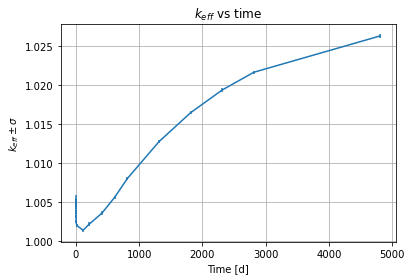

In [16]:
pyplot.errorbar(time,k[:,0],yerr=k[:,1]);
pyplot.xlabel('Time [d]');
pyplot.ylabel('$k_{eff}\pm \sigma$');
pyplot.title("$k_{eff}$ vs time");
pyplot.grid();

obviously, these results suck.  A better analysis would use more particles at least and probably smaller time steps.

In [17]:
_time, pu239 = results.get_atoms("1","Pu239");
_time, pu240 = results.get_atoms("1","Pu240");
_time, pu241 = results.get_atoms("1","Pu241");

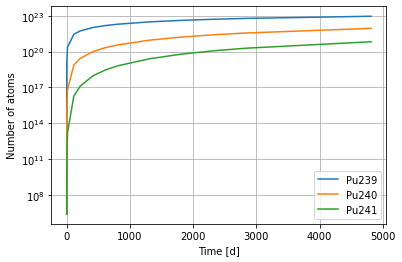

In [18]:
pyplot.semilogy(time,pu239,label="Pu239");
pyplot.semilogy(time,pu240,label="Pu240");
pyplot.semilogy(time,pu241,label="Pu241");
pyplot.grid();
pyplot.xlabel('Time [d]');
pyplot.ylabel('Number of atoms');
pyplot.legend();


In [19]:
mass_pu239 = pu239*(239./6.022e23);
mass_pu240 = pu240*(240./6.022e23);
mass_pu241 = pu241*(241./6.022e23);

mass_pu = mass_pu239 + mass_pu240 + mass_pu241

In [20]:
pu_239_ratio = mass_pu239/mass_pu

In [21]:
print(pu_239_ratio)

[0.33194444 0.999973   0.99997037 0.99996563 0.99995978 0.99995089
 0.99993338 0.99973356 0.9973932  0.99505175 0.9904329  0.98589889
 0.98144173 0.97063594 0.96027807 0.95030552 0.94069983 0.905245  ]


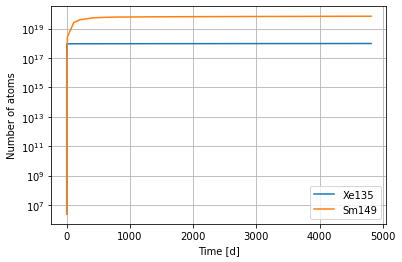

In [22]:
_time, xe135 = results.get_atoms("1","Xe135")
_time, sm149 = results.get_atoms("1","Sm149")

pyplot.semilogy(time,xe135,label="Xe135");
pyplot.semilogy(time,sm149,label="Sm149");
pyplot.grid();
pyplot.xlabel('Time [d]');
pyplot.ylabel('Number of atoms');
pyplot.legend();
